In [1]:
# import libraries
from imblearn.over_sampling import SMOTE, SMOTENC, SMOTEN
import joblib
import logging
import matplotlib.pyplot as plt
from mordred import Calculator, descriptors
import numpy as np
import os
import pandas as pd
from PIL import Image
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import seaborn as sns
import shap
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# own module
from pythia import classification_metrics as cmetrics
from pythia import fingerprints_generation as fp
from pythia import molecules_and_structures as mi
from pythia import workflow_functions as cwf

# utility
%load_ext autoreload
%autoreload 2
%aimport

# set up logging
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)

# set random seed
random_seed = 10459
np.random.seed = random_seed
np.random.RandomState(random_seed)
log.info(f"Random seed fixed as {random_seed}")

# set pandas options
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

Random seed fixed as 10459


Modules to reload:
all-except-skipped

Modules to skip:



# Machine Learning

In this section, we implement a train-test split strategy. The models are trained on the training set and then evaluated on the test set.

# Load target data

First we read the dataset from a csv file. A csv file is a comma separated file, where each row is a data point.

`pd.read_csv()` is used to read the input csv file that contain the dataset. The dataset is stored in a dataframe, which is a data structure provided by the pandas library. A dataframe is a two-dimensional data structure, i.e. data is aligned in a tabular fashion in rows and columns. The dataframe can be indexed by column names.

Here, we also reformat the column names to replace spaces with underscores and make the column names all lower case. This is done to make it easier to work with the data.

In [2]:
data = pd.read_csv("../Notebook1-dataset-analysis/df_all_substructure_onehot.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

**THE CELL BELOW IS OPTIONAL!** In our dataset, transporters with no activity data are left blank, so we fill these with 'N' for 'No Activity' and then convert to binary. You can delete this cell if you are using your own dataset with fully-provided target data.

In [3]:
data['logec50'] = data['target'].fillna('N')

##  Train-test split

We split the dataset into a training and test set by temporal split. The training set contains all compounds up to 2020, while the test set contains all compounds reported in 2021.

First we take a look at the distribution of the number of compounds reported each year.

In [4]:
log.info("Number of years in the dataset: " + str(len(data["year"].unique())))
log.info("Years in the dataset are: " + str(data["year"].sort_values().unique()))
log.info("Number of compounds per year: " + str(data.groupby("year").size().tolist()))

Number of years in the dataset: 11
Years in the dataset are: [2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
Number of compounds per year: [16, 27, 33, 41, 18, 66, 22, 7, 8, 22, 44]


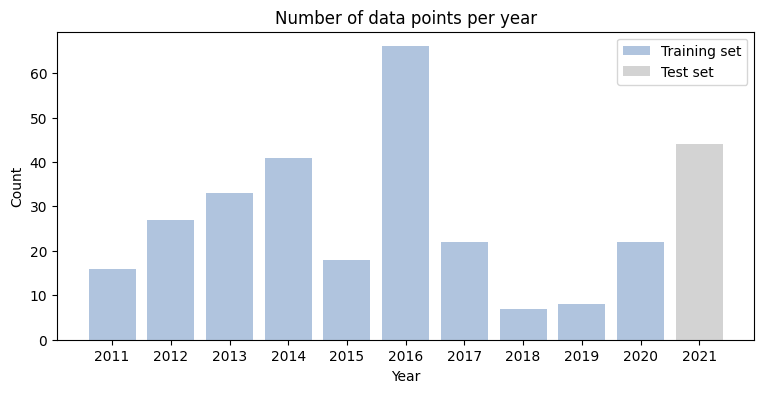

In [5]:
# sort by year
data = data.sort_values(by=['year'])

# plot the number of data points per year
plt.figure(figsize= (9, 4))
plt.style.use('default')
plt.title('Number of data points per year')
plt.bar(data['year'].unique(), data.groupby('year').size().tolist(), color="lightsteelblue", label='Training set')
plt.bar(data['year'].unique()[-1], data.groupby('year').size().tolist()[-1], color="lightgrey", label='Test set')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(data['year'].unique())
plt.legend()
plt.savefig('fig_year_count.png', dpi=300)
plt.show()

Then we split the dataset into a training and test set by temporal split. The training set contains all compounds up to 2020, while the test set contains all compounds reported in 2021.

In [6]:
# select the IDs of the test data (2021)
test_dataid = []
for year in data['year'].unique():
    if year == 2021:
        test_dataid.append(data[data['year'] == year].index.tolist())
test_dataid = [item for sublist in test_dataid for item in sublist]

log.info('Number of test data: {}'.format(len(test_dataid)))
log.info('Test data IDs: {}'.format(test_dataid))

# create a test set dataframe
test_data = pd.DataFrame()
test_data = data.loc[test_dataid] # get test data using test_dataid
test_data = test_data.reset_index(drop=True) # reset index
test_data.to_csv('test_data.csv', index=False)

# create a train set dataframe
train_data = data.drop(index=test_dataid, axis=0, inplace = False) # drop test data by excluding test_dataid
train_data = train_data.reset_index(drop=True) # reset index
train_data.to_csv('train_data.csv', index=False)

Number of test data: 44
Test data IDs: [93, 91, 92, 90, 89, 125, 126, 127, 94, 83, 96, 97, 98, 128, 99, 100, 101, 102, 103, 95, 129, 140, 131, 84, 85, 86, 87, 105, 88, 144, 143, 142, 141, 82, 139, 138, 137, 136, 135, 134, 133, 132, 130, 104]


Double check that the training and test sets are split correctly by looking at the 'year' column.

In [7]:
log.info('Year of train data: {}'.format(train_data['year'].unique()))
log.info('Year of test data: {}'.format(test_data['year'].unique()))

Year of train data: [2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
Year of test data: [2021]


Next, we will define the input SMILES and target values for the training and test sets.

In [8]:
# define input SMILES and target values for training set
substratesmiles_train = train_data["canonical_smiles"]
train_mols = [Chem.MolFromSmiles(smiles) for smiles in substratesmiles_train]
log.info("Transporter SMILES: {}".format(substratesmiles_train.head()))

target_train = train_data["logec50"]
log.info("logEC50: {}".format(target_train.head()))

Transporter SMILES: 0    CC(C)CCNC(=S)Nc1cccc2cc[nH]c12
1                CCCCNC(=O)NCCC(C)C
2                CCCCNC(=S)NCCC(C)C
3            CC(C)CCNC(=O)Nc1ccccc1
4            CC(C)CCNC(=S)Nc1ccccc1
Name: canonical_smiles, dtype: object
logEC50: 0   -1.537602
1           N
2   -0.962574
3           N
4    0.483872
Name: logec50, dtype: object


In [9]:
# define input SMILES and target values for test set
substratesmiles_test = test_data["canonical_smiles"]
test_mols = [Chem.MolFromSmiles(smiles) for smiles in substratesmiles_test]
log.info("Transporter SMILES: {}".format(substratesmiles_test.head()))

target_test = test_data["logec50"]
log.info("logEC50: {}".format(target_test.head()))

Transporter SMILES: 0       S=C(Nc1cccc2sccc12)Nc1cccc2sccc12
1    S=C(NC1=CSC2C=CC=CC12)Nc1csc2ccccc12
2       O=C(Nc1cccc2sccc12)Nc1cccc2sccc12
3    O=C(NC1=CSC2C=CC=CC12)Nc1csc2ccccc12
4              CCCCCCNC(=S)Nc1cccc2sccc12
Name: canonical_smiles, dtype: object
logEC50: 0           N
1    0.301594
2           N
3           N
4           N
Name: logec50, dtype: object


## Visualization of the structural diversity in the Training and Test Set

Tanimoto similarity matrix of the training set and test set based on Morgan fingerprints, as well as the Tanimoto similarity between the training and test set can be visualized using ***mi.tanimoto_similarity_comparison*** function. The function will save a figure with all three Tanimoto similarity matrices in the current working directory.

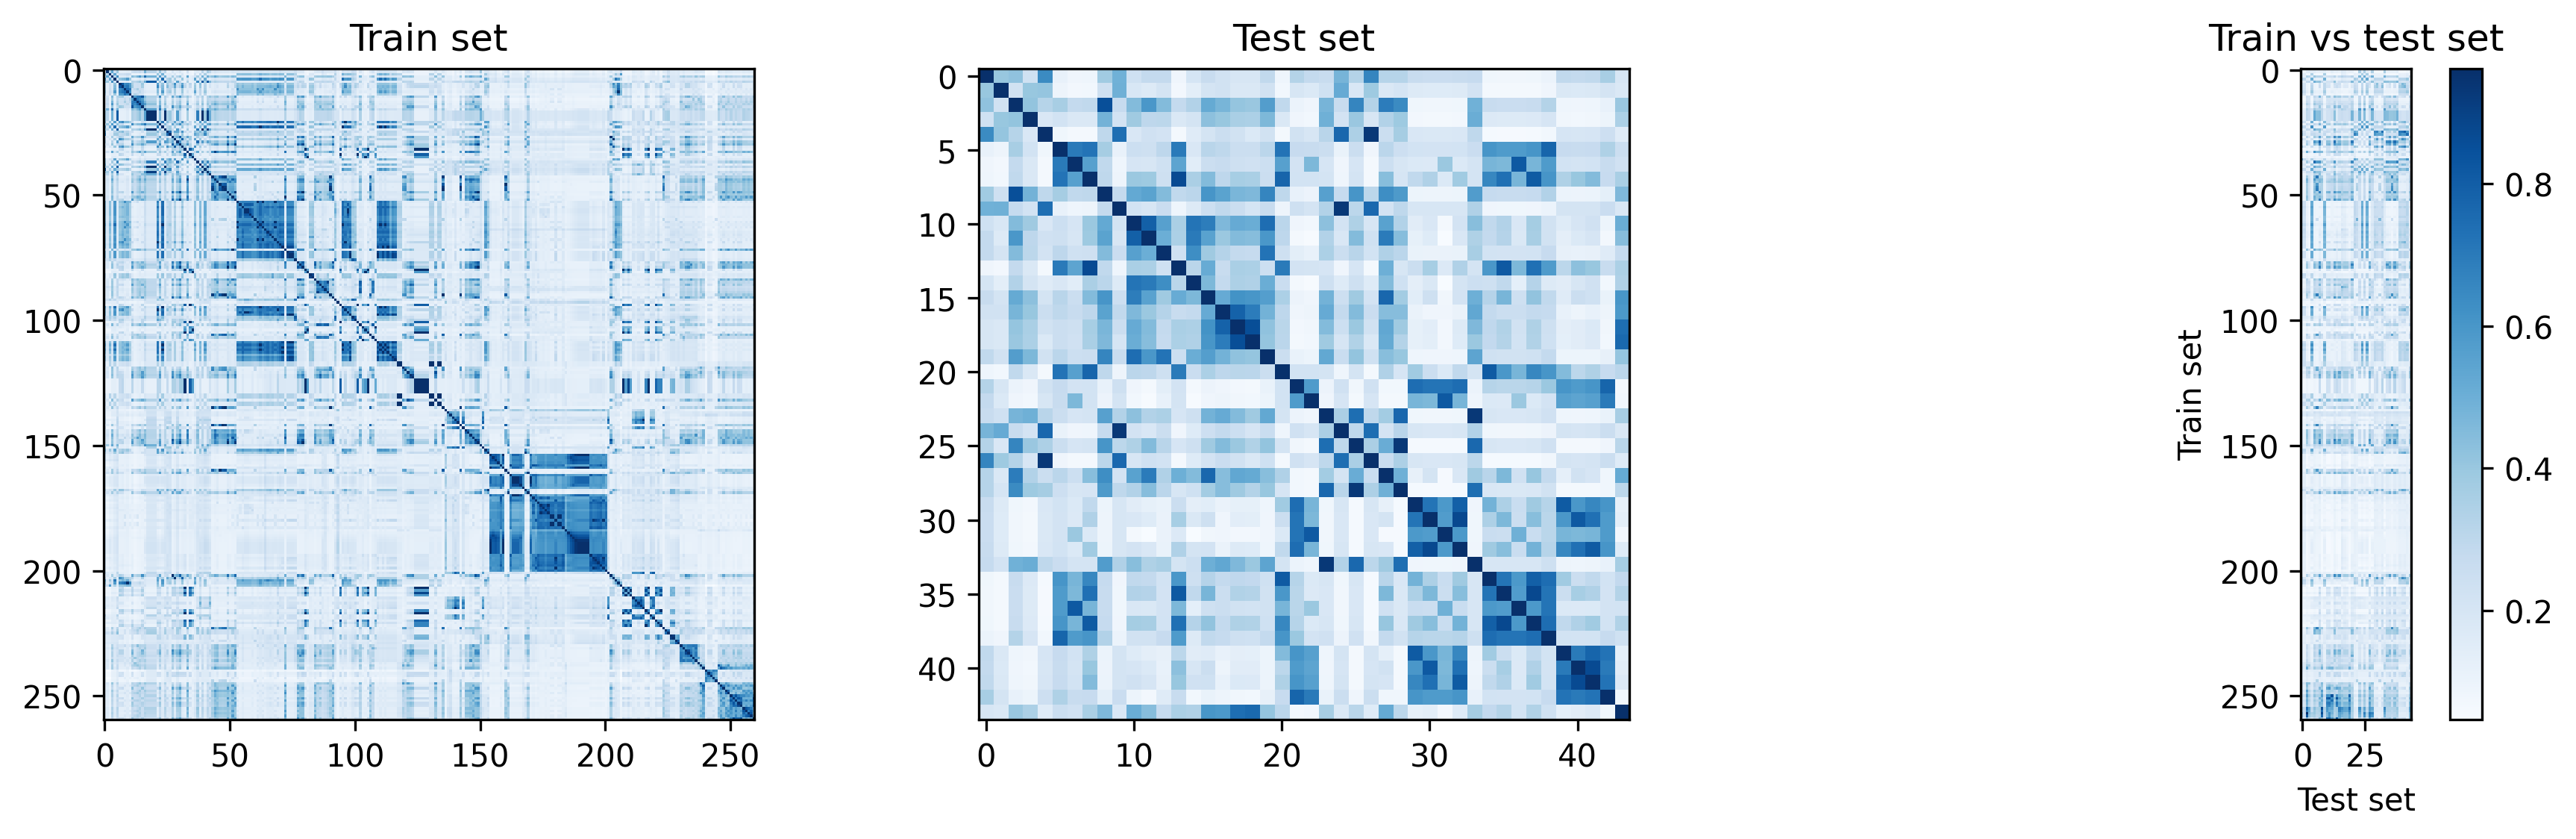

In [10]:
morgan_fps_train, morgan_fps_train_df =  fp.morgan_fingerprints(substratesmiles_train, bit_vec=True)
morgan_fps_test, morgan_fps_test_df =  fp.morgan_fingerprints(substratesmiles_test, bit_vec=True)

mi.tanimoto_similarity_comparison(morgan_fps_train, morgan_fps_test, figsize=(12, 4))

# Handling the training set

## Classify the training data

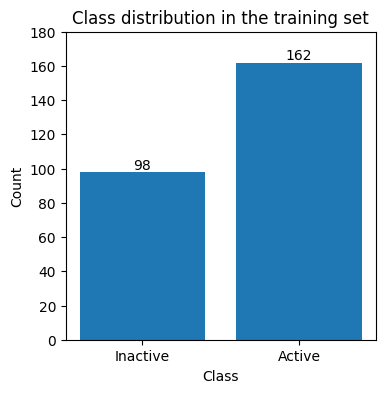

In [11]:
# define the classes for the training set
classes_train=[]
for index, value in target_train.items():
    if value == 'N' or value > 0:
        classes_train.append(0)
    else:
        classes_train.append(1)

# plot the distribution of the classes in the training set
plt.figure(figsize=(4,4))
plt.bar(['Inactive', 'Active'], [classes_train.count(0), classes_train.count(1)])
plt.title('Class distribution in the training set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.ylim(0, 180)
for i in range(2):
    plt.text(i, classes_train.count(i), classes_train.count(i), ha = 'center', va = 'bottom')
plt.show()

In [12]:
class_targets_df_train = pd.DataFrame(np.array([classes_train]).T, columns=["classes"])

## Generate features for the training set

In [13]:
submolecule_list_train = [Chem.MolFromSmiles(smiles) for smiles in substratesmiles_train]
calc = Calculator(descriptors, ignore_3D=True)
subfeatures_df_train = calc.pandas(submolecule_list_train)

100%|██████████| 260/260 [00:33<00:00,  7.78it/s]


In [14]:
# Drop columns with NaN values
subfeatures_df_train.dropna(inplace=True, thresh=int(0.9*len(subfeatures_df_train.index)))

# Drop columns with values containing the string 'missing'
subfeatures_df_train.drop(subfeatures_df_train.columns[subfeatures_df_train.isin(['missing']).any()], axis=1, inplace=True)

subfeatures_df_train.columns = [ent.strip() for ent in subfeatures_df_train.columns]
subfeatures_df_train.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,...,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,13.682318,11.938414,0,0,22.381359,...,22,88.0,99.0,6.055556,4.055556
1,8.813451,8.413992,0,0,14.733860,...,11,50.0,49.0,5.972222,3.250000
2,8.813451,8.413992,0,0,14.733860,...,11,50.0,49.0,5.972222,3.250000
3,10.934771,9.613927,0,0,18.048677,...,15,66.0,69.0,5.583333,3.500000
4,10.934771,9.613927,0,0,18.048677,...,15,66.0,69.0,5.583333,3.500000


## Pearson correlation coefficent and Spearman's rank correlation coefficient
In the next cells we can investigate how well each bit correlates against our property of interest and checks for signficance using a one tail permutation test: how many times out of the n_sample do I obtain a correlation coefficient that is greater than the observed value.

In the next block the feature with a reasonable correlation and statistically significant are chosen. The sig_metric is the significance testing metric correlation coefficent names are two tail p tests. to do one tail enter replacing option with gt for greater than and lt for less than and the correction coefficent name one of pearsron, spearman or kendalltau, onetail_$option_$correlation_coefficent.

In [15]:
subreasonable_predicted_properties, subsignificant_features = cwf.find_correlating_features(subfeatures_df_train, classes_train, thresh=0.3, 
                                                                                      plot=False, corr_method="spearman", 
                                                                                      sig_metric="spearman", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

[1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
Significance will be calculated for the correlations
nBase: 0.3182 P: 0.0002 Significant at 0.0500 level? True
BCUTc-1h: 0.3269 P: 0.0002 Significant at 0.0500 level? True
NdsCH: 0.3304 P: 0.0002 Significant at 0.0500 l

In [16]:
#subreasonable_predicted_properties, subsignificant_features
log.info("{} {}".format(len(subreasonable_predicted_properties), subsignificant_features))
log.info("{} {}".format(len(subsignificant_features), subreasonable_predicted_properties))
use_reasonable = False
use_significant = True

7 ['nBase', 'BCUTc-1h', 'NdsCH', 'SdsCH', 'PEOE_VSA12', 'n5ARing', 'n5AHRing']
7 ['nBase', 'BCUTc-1h', 'NdsCH', 'SdsCH', 'PEOE_VSA12', 'n5ARing', 'n5AHRing']


In [17]:
subfeats_df_train = pd.DataFrame()

if use_significant is True:
    for k in subsignificant_features:
        subfeats_df_train[k] = subfeatures_df_train[k]
        
elif use_reasonable is True:
    for k in subreasonable_predicted_properties:
        subfeats_df_train[k] = subfeatures_df_train[k]

In [18]:
subfeats_df_train.head()

,nBase,BCUTc-1h,NdsCH,SdsCH,PEOE_VSA12,n5ARing,n5AHRing
0,0,0.382472,0,0.0,0.0,0,0
1,0,0.417560,0,0.0,0.0,0,0
2,0,0.329469,0,0.0,0.0,0,0
3,0,0.423114,0,0.0,0.0,0,0
4,0,0.342046,0,0.0,0.0,0,0


## Feature categorization

In the following cell, we discretize the features that are categorial. We use the ***cwf.feature_categorization*** function to do this. The function takes a dataframe as input and returns a dataframe with the discretized features. When there is a mix of numerical and categorical features, i.e., when feature_types = "some_categorical", we sugguest the user provide the indices for the categorial features. If not provided, the function will try to guess the categorial features automatically. However, the user should check the output to make sure the automatic guess is correct.


In [19]:
help(cwf.feature_categorization)

Help on function feature_categorization in module pythia.workflow_functions:

feature_categorization(features_df, feature_types='some_categorical', categorical_indxs=None)
    function to determine the type of scaling for the features
    
    :param features_df: dataframe of original features
    :param feature_types: are they all categorical, some categorical or non categorical features
    :param categorical_indxs: indices of the categorial features. We sugguest the user provide the indices for the categorial features when feature_types="some_categorial". If not provided, the function will try to guess the categorial features automatically.
    :return: new dataframe with scaled and one-hotencoded features



In [20]:
features_df_train_scaled, categorical_indxs_train = cwf.feature_categorization(subfeats_df_train, 
                                                                               feature_types = "some_categorical")

-----
Categorical features not provided. Trying to guess the categorical features automatically.
-----
Automatically assigned categorical indices:
[0, 2, 5, 6] 4
Automatically assigned categorical features:
['nBase', 'NdsCH', 'n5ARing', 'n5AHRing'] 4
**Please check if the automatic assignment is correct. If not, please provide the indices of the categorical features.**
-----
Numerical features:
['BCUTc-1h', 'SdsCH', 'PEOE_VSA12'] 3
Categorical features:
['nBase', 'NdsCH', 'n5ARing', 'n5AHRing'] 4
Index(['BCUTc-1h', 'SdsCH', 'PEOE_VSA12', 'nBase_0', 'nBase_1', 'NdsCH_0',
       'NdsCH_1', 'NdsCH_2', 'n5ARing_0', 'n5ARing_1', 'n5AHRing_0',
       'n5AHRing_1'],
      dtype='object')
     BCUTc-1h  SdsCH  PEOE_VSA12  nBase_0  nBase_1  ...  NdsCH_2  n5ARing_0  \
0    0.175952    0.0         0.0      1.0      0.0  ...      0.0        1.0   
1    0.292430    0.0         0.0      1.0      0.0  ...      0.0        1.0   
2    0.000000    0.0         0.0      1.0      0.0  ...      0.0        1

## Add MACCS keys as structual features

In [21]:
fps1_train, fps_df1_train = fp.maccskeys_fingerprints(substratesmiles_train)
# remove columns with all 0s
fps1 = fps_df1_train.loc[:, (fps_df1_train != 0).any(axis=0)]

# add 'fp_' prefix to the column names
fps1.columns = ['fp_' + str(col) for col in fps1.columns]

# combine the features 
features_df_train_scaled = pd.concat([features_df_train_scaled, fps1], axis=1)
features_df_train_scaled

,BCUTc-1h,SdsCH,PEOE_VSA12,nBase_0,nBase_1,...,fp_161,fp_162,fp_163,fp_164,fp_165
0,0.175952,0.0,0.0,1.0,0.0,...,1,1,1,0,1
1,0.292430,0.0,0.0,1.0,0.0,...,1,0,0,1,0
2,0.000000,0.0,0.0,1.0,0.0,...,1,0,0,0,0
3,0.310867,0.0,0.0,1.0,0.0,...,1,1,1,1,1
4,0.041751,0.0,0.0,1.0,0.0,...,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
255,0.359308,0.0,0.0,1.0,0.0,...,1,1,1,1,1
256,0.389939,0.0,0.0,1.0,0.0,...,1,1,1,1,1
257,0.357499,0.0,0.0,1.0,0.0,...,1,1,1,1,1
258,0.388668,0.0,0.0,1.0,0.0,...,1,1,1,1,1


### Add in some experimental / custom features

In [22]:
feats_to_add = ['cl_conc_(mm)', 'time_between_transporter_added_and_lysis_(s)', 'assay_ph']

train_data = train_data.reset_index(drop=True)

for f in feats_to_add:
    print(f)
    # add the feature to the features_df_train_scaled dataframe
    features_df_train_scaled.loc[:, f] = train_data[f]

cl_conc_(mm)
time_between_transporter_added_and_lysis_(s)
assay_ph


In [23]:
features_df_train_scaled

,BCUTc-1h,SdsCH,PEOE_VSA12,nBase_0,nBase_1,...,fp_164,fp_165,cl_conc_(mm),time_between_transporter_added_and_lysis_(s),assay_ph
0,0.175952,0.0,0.0,1.0,0.0,...,0,1,489,270,7.2
1,0.292430,0.0,0.0,1.0,0.0,...,1,0,489,270,7.2
2,0.000000,0.0,0.0,1.0,0.0,...,0,0,489,270,7.2
3,0.310867,0.0,0.0,1.0,0.0,...,1,1,489,270,7.2
4,0.041751,0.0,0.0,1.0,0.0,...,0,1,489,270,7.2
...,...,...,...,...,...,...,...,...,...,...,...
255,0.359308,0.0,0.0,1.0,0.0,...,1,1,487,270,7.2
256,0.389939,0.0,0.0,1.0,0.0,...,1,1,487,270,7.2
257,0.357499,0.0,0.0,1.0,0.0,...,1,1,487,270,7.2
258,0.388668,0.0,0.0,1.0,0.0,...,1,1,487,270,7.2


In [24]:
features_df_train = features_df_train_scaled.copy()

In [25]:
features_df_train.head()

,BCUTc-1h,SdsCH,PEOE_VSA12,nBase_0,nBase_1,...,fp_164,fp_165,cl_conc_(mm),time_between_transporter_added_and_lysis_(s),assay_ph
0,0.175952,0.0,0.0,1.0,0.0,...,0,1,489,270,7.2
1,0.292430,0.0,0.0,1.0,0.0,...,1,0,489,270,7.2
2,0.000000,0.0,0.0,1.0,0.0,...,0,0,489,270,7.2
3,0.310867,0.0,0.0,1.0,0.0,...,1,1,489,270,7.2
4,0.041751,0.0,0.0,1.0,0.0,...,0,1,489,270,7.2


In [26]:
features_df_train.to_csv("features_train.csv")

In [27]:
feature_types = 'some_categorical'

## Synthetic sampling for the training

In [28]:
nneighbours = min(5, len(class_targets_df_train[class_targets_df_train["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

# feature_types is set when the fingerprints are calculated
# No catagorical
if feature_types == "no_categorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some catagorical - Need to provide the indexes
elif feature_types == "some_categorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=categorical_indxs_train, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All catagorical
elif feature_types == "categorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


In [29]:
log.info("Number of features: {}".format(len(features_df_train.columns.values)))
log.info("Feature decriptions:\n{}".format(features_df_train.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df_train.columns.values))

Number of features: 141
Feature decriptions:
['BCUTc-1h' 'SdsCH' 'PEOE_VSA12' 'nBase_0' 'nBase_1' 'NdsCH_0' 'NdsCH_1'
 'NdsCH_2' 'n5ARing_0' 'n5ARing_1' 'n5AHRing_0' 'n5AHRing_1' 'fp_11'
 'fp_24' 'fp_27' 'fp_31' 'fp_36' 'fp_37' 'fp_38' 'fp_41' 'fp_42' 'fp_43'
 'fp_45' 'fp_46' 'fp_47' 'fp_49' 'fp_50' 'fp_51' 'fp_52' 'fp_54' 'fp_55'
 'fp_56' 'fp_58' 'fp_59' 'fp_60' 'fp_61' 'fp_62' 'fp_63' 'fp_64' 'fp_65'
 'fp_66' 'fp_67' 'fp_69' 'fp_70' 'fp_71' 'fp_72' 'fp_73' 'fp_74' 'fp_75'
 'fp_76' 'fp_77' 'fp_78' 'fp_79' 'fp_80' 'fp_81' 'fp_82' 'fp_83' 'fp_85'
 'fp_86' 'fp_87' 'fp_88' 'fp_89' 'fp_90' 'fp_91' 'fp_92' 'fp_93' 'fp_94'
 'fp_95' 'fp_96' 'fp_97' 'fp_98' 'fp_99' 'fp_100' 'fp_101' 'fp_102'
 'fp_103' 'fp_104' 'fp_105' 'fp_106' 'fp_107' 'fp_108' 'fp_109' 'fp_110'
 'fp_111' 'fp_112' 'fp_113' 'fp_114' 'fp_115' 'fp_116' 'fp_117' 'fp_118'
 'fp_119' 'fp_120' 'fp_121' 'fp_122' 'fp_123' 'fp_124' 'fp_125' 'fp_126'
 'fp_127' 'fp_128' 'fp_129' 'fp_130' 'fp_131' 'fp_132' 'fp_133' 'fp_134'
 'fp_135' 'fp_1

In [30]:
# drop columns with missing values in features_df_train
features_df_train = features_df_train.dropna(axis=1)

In [31]:
features_smote_train, classes_smote_train = sm.fit_resample(features_df_train.to_numpy(), class_targets_df_train.to_numpy())
n_sythetic_points = features_smote_train.shape[0] - len(features_df_train.index)
log.info("SMOTE has added {} sythetic features to balance the classes".format(n_sythetic_points))

The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
SMOTE has added 64 sythetic features to balance the classes


In [32]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote_train, features_smote_train.shape, classes_smote_train, classes_smote_train.shape))

Resampled X
[[1.75952366e-01 0.00000000e+00 0.00000000e+00 ... 4.89000000e+02
  2.70000000e+02 7.20000000e+00]
 [2.92429550e-01 0.00000000e+00 0.00000000e+00 ... 4.89000000e+02
  2.70000000e+02 7.20000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.89000000e+02
  2.70000000e+02 7.20000000e+00]
 ...
 [5.89673695e-01 0.00000000e+00 0.00000000e+00 ... 5.00000000e+02
  3.00000000e+02 7.20000000e+00]
 [7.17476701e-01 0.00000000e+00 0.00000000e+00 ... 4.89000000e+02
  2.70000000e+02 7.20000000e+00]
 [3.48504964e-01 0.00000000e+00 0.00000000e+00 ... 4.88786349e+02
  2.70000000e+02 7.20000000e+00]]
(324, 141)
Resampled y:
[1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0
 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0
 1 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1

In [33]:
features_smote_df_train = pd.DataFrame(data=features_smote_train, columns=features_df_train.columns.values)
classes_smote_df_train = pd.DataFrame(data=classes_smote_train, columns=["classes"])

comb_df_res = features_smote_df_train.copy()
comb_df_res["classes"] = classes_smote_train
comb_df_res.to_csv("resampled_synthetic_data_set_train.csv")
comb_df_res

,BCUTc-1h,SdsCH,PEOE_VSA12,nBase_0,nBase_1,...,fp_165,cl_conc_(mm),time_between_transporter_added_and_lysis_(s),assay_ph,classes
0,0.175952,0.0,0.0,1.0,0.0,...,1.0,489.000000,270.0,7.2,1
1,0.292430,0.0,0.0,1.0,0.0,...,0.0,489.000000,270.0,7.2,0
2,0.000000,0.0,0.0,1.0,0.0,...,0.0,489.000000,270.0,7.2,1
3,0.310867,0.0,0.0,1.0,0.0,...,1.0,489.000000,270.0,7.2,0
4,0.041751,0.0,0.0,1.0,0.0,...,1.0,489.000000,270.0,7.2,0
...,...,...,...,...,...,...,...,...,...,...,...
319,0.041794,0.0,0.0,1.0,0.0,...,1.0,489.000000,270.0,7.2,0
320,0.041794,0.0,0.0,1.0,0.0,...,1.0,489.000000,270.0,7.2,0
321,0.589674,0.0,0.0,1.0,0.0,...,1.0,500.000000,300.0,7.2,0
322,0.717477,0.0,0.0,1.0,0.0,...,1.0,489.000000,270.0,7.2,0


# Handling the Test set

## Classify the test set

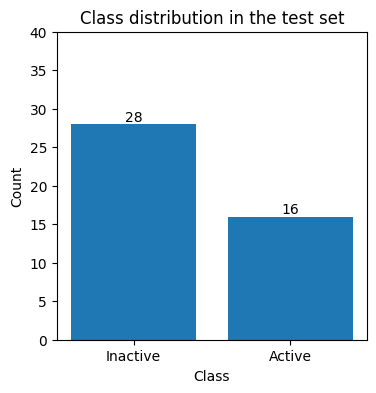

In [34]:
classes_test=[]
for index, value in target_test.items():
    if value == 'N' or value > 0:
        classes_test.append(0)
    else:
        classes_test.append(1)

# plot the distribution of the classes in the test set
plt.figure(figsize=(4,4))
plt.bar(['Inactive', 'Active'], [classes_test.count(0), classes_test.count(1)])
plt.title('Class distribution in the test set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.ylim(0, 40)
# show counts on the bars
for i in range(2):
    plt.text(i, classes_test.count(i), classes_test.count(i), ha = 'center', va = 'bottom')
plt.show()

## Generate features for the test set

In [35]:
submolecule_list_test= [Chem.MolFromSmiles(smiles) for smiles in substratesmiles_test]

In [36]:
calc = Calculator(descriptors, ignore_3D=True)
subfeatures_df_test = calc.pandas(submolecule_list_test)

100%|██████████| 44/44 [00:07<00:00,  5.63it/s]


In [37]:
features_df_test_scaled, categorical_indxs_test = cwf.feature_categorization(subfeatures_df_test)

-----
Categorical features not provided. Trying to guess the categorical features automatically.
-----
Automatically assigned categorical indices:
[2, 3, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 771, 772, 773, 774, 775, 776, 777, 778, 779, 782, 783, 784, 785, 786, 787, 788, 789, 790, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 977, 979, 983, 984, 989, 990, 991, 992, 995, 996, 997, 998, 999, 1001, 1002, 1003, 1006, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038

## MACCS keys for strucrual features

In [38]:
fps1_test, fps_df1_test = fp.maccskeys_fingerprints(substratesmiles_test)

# remove columns with all 0s
fps1 = fps_df1_test.loc[:, (fps_df1_test != 0).any(axis=0)]

# add 'fp_' prefix to the column names
fps1.columns = ['fp_' + str(col) for col in fps1.columns]

features_df_test_scaled = pd.concat([features_df_test_scaled, fps_df1_test], axis=1)

## Add experimental features

In [39]:
for f in feats_to_add:
    features_df_test_scaled[f] = test_data[f]

test_data = test_data.reset_index(drop=True)   

# change column name "time_between_transporter_added_and_lysis_(s)" to  "$\Delta t$"
# change column name "cl_conc_(mm)" to "[Cl$^{-}]$"
#features_df_test = features_df_test.rename(columns={"time_between_transporter_added_and_lysis_(s)": "$\Delta t$", "cl_conc_(mm)": "[Cl$^{-}]$"})

In [40]:
testfeats_df_sub = pd.DataFrame()
testcontinous_features = []
testcatagorical_features = []

# Make sure feature cover all of the molecule if not don't use them as we will loose data points doing this
n_features = len(target_train)
print("Number of features: ", n_features)
print(features_df_train.columns)

for ent in features_df_train.columns:
    if ent in features_df_test_scaled.columns:
        testfeats_df_sub[ent] = features_df_test_scaled[ent].values 
        testcontinous_features.append(ent)
    else:
        testfeats_df_sub[ent] = 0.0

Number of features:  260
Index(['BCUTc-1h', 'SdsCH', 'PEOE_VSA12', 'nBase_0', 'nBase_1', 'NdsCH_0',
       'NdsCH_1', 'NdsCH_2', 'n5ARing_0', 'n5ARing_1',
       ...
       'fp_159', 'fp_160', 'fp_161', 'fp_162', 'fp_163', 'fp_164', 'fp_165',
       'cl_conc_(mm)', 'time_between_transporter_added_and_lysis_(s)',
       'assay_ph'],
      dtype='object', length=141)


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [41]:
features_df_test = testfeats_df_sub.copy()

In [42]:
# makesure the columns are in the same order
features_df_test = features_df_test[features_df_train.columns]


In [43]:
features_df_test.columns

Index(['BCUTc-1h', 'SdsCH', 'PEOE_VSA12', 'nBase_0', 'nBase_1', 'NdsCH_0',
       'NdsCH_1', 'NdsCH_2', 'n5ARing_0', 'n5ARing_1',
       ...
       'fp_159', 'fp_160', 'fp_161', 'fp_162', 'fp_163', 'fp_164', 'fp_165',
       'cl_conc_(mm)', 'time_between_transporter_added_and_lysis_(s)',
       'assay_ph'],
      dtype='object', length=141)

In [44]:
features_df_test.head()

,BCUTc-1h,SdsCH,PEOE_VSA12,nBase_0,nBase_1,...,fp_164,fp_165,cl_conc_(mm),time_between_transporter_added_and_lysis_(s),assay_ph
0,0.044687,0.000000,0.0,1.0,0.0,...,0.0,0.0,489,270,7.2
1,0.023163,1.000000,0.0,1.0,0.0,...,0.0,0.0,489,270,7.2
2,0.238604,0.000000,0.0,1.0,0.0,...,0.0,0.0,489,270,7.2
3,0.234885,0.961859,0.0,1.0,0.0,...,0.0,0.0,489,270,7.2
4,0.000567,0.000000,0.0,1.0,0.0,...,0.0,0.0,489,270,7.2


# Define Xtrain, Xtest, Ytrain, Ytest

In [45]:
Xtrain = features_df_train
Xtest = features_df_test
Ytrain = class_targets_df_train
Ytest = classes_test

In [46]:
Xtrain.head()

,BCUTc-1h,SdsCH,PEOE_VSA12,nBase_0,nBase_1,...,fp_164,fp_165,cl_conc_(mm),time_between_transporter_added_and_lysis_(s),assay_ph
0,0.175952,0.0,0.0,1.0,0.0,...,0,1,489,270,7.2
1,0.292430,0.0,0.0,1.0,0.0,...,1,0,489,270,7.2
2,0.000000,0.0,0.0,1.0,0.0,...,0,0,489,270,7.2
3,0.310867,0.0,0.0,1.0,0.0,...,1,1,489,270,7.2
4,0.041751,0.0,0.0,1.0,0.0,...,0,1,489,270,7.2


In [47]:
Xtest.head()

,BCUTc-1h,SdsCH,PEOE_VSA12,nBase_0,nBase_1,...,fp_164,fp_165,cl_conc_(mm),time_between_transporter_added_and_lysis_(s),assay_ph
0,0.044687,0.000000,0.0,1.0,0.0,...,0.0,0.0,489,270,7.2
1,0.023163,1.000000,0.0,1.0,0.0,...,0.0,0.0,489,270,7.2
2,0.238604,0.000000,0.0,1.0,0.0,...,0.0,0.0,489,270,7.2
3,0.234885,0.961859,0.0,1.0,0.0,...,0.0,0.0,489,270,7.2
4,0.000567,0.000000,0.0,1.0,0.0,...,0.0,0.0,489,270,7.2


In [48]:
# save all the dataframes to csv files
Xtrain.to_csv('Xtrain.csv', index=False)
Xtest.to_csv('Xtest.csv', index=False)
Ytrain.to_csv('ytrain.csv', index=False)
pd.DataFrame(Ytest).to_csv('ytest.csv', index=False)

# Time for ML

In [49]:
kfold_clf_names = [
    "Nearest Neighbors", 
    "Gaussian Process",
    "Decision Tree", 
    "AdaBoost",
    "Logistic Regression"]

kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs")]

kfold_classifier_parameters = {
    "Nearest Neighbors": {"n_neighbors": [ent for ent in range(2, 10, 2)]},
    "Gaussian Process": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "Decision Tree": {"max_depth": [ent for ent in range(2, 10, 2)]},
    "AdaBoost": {"n_estimators": [2, 3, 5]},
    "Logistic Regression": {"penalty":["l2"], "C": [0.75, 1.0, 1.25, 1.5]}
}

Features: Index(['BCUTc-1h', 'SdsCH', 'PEOE_VSA12', 'nBase_0', 'nBase_1', 'NdsCH_0',
       'NdsCH_1', 'NdsCH_2', 'n5ARing_0', 'n5ARing_1',
       ...
       'fp_159', 'fp_160', 'fp_161', 'fp_162', 'fp_163', 'fp_164', 'fp_165',
       'cl_conc_(mm)', 'time_between_transporter_added_and_lysis_(s)',
       'assay_ph'],
      dtype='object', length=141)
Using unscaled features
data:
     index  BCUTc-1h  SdsCH  PEOE_VSA12  nBase_0  nBase_1  NdsCH_0  NdsCH_1  \
0        0  0.175952    0.0         0.0      1.0      0.0      1.0      0.0   
1        1  0.292430    0.0         0.0      1.0      0.0      1.0      0.0   
2        2  0.000000    0.0         0.0      1.0      0.0      1.0      0.0   
3        3  0.310867    0.0         0.0      1.0      0.0      1.0      0.0   
4        4  0.041751    0.0         0.0      1.0      0.0      1.0      0.0   
..     ...       ...    ...         ...      ...      ...      ...      ...   
255    255  0.359308    0.0         0.0      1.0      0.0      1

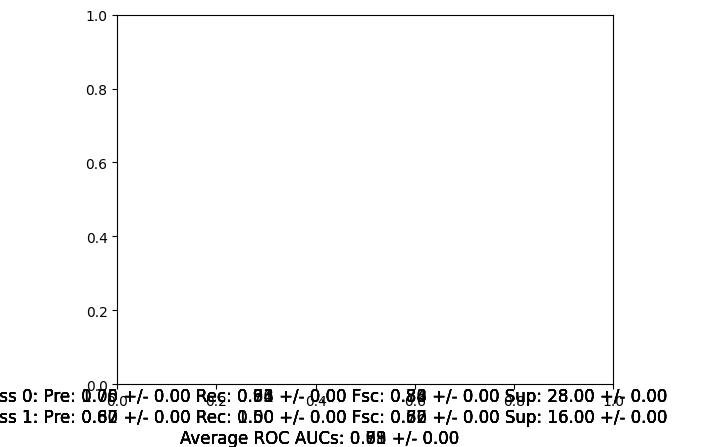

In [50]:
cwf.test_classifiers_with_optimization(Xtrain, Xtest, Ytrain, Ytest, kfold_classifiers, kfold_classifier_parameters, 
                                        overwrite=True, cv=5, n_repeats=10,
                                        clf_names=kfold_clf_names, class_labels=(0,1))

In [51]:
directory_names = cwf.directory_names(kfold_clf_names)
directory_names

['Nearest_Neighbors',
 'Gaussian_Process',
 'Decision_Tree',
 'AdaBoost',
 'Logistic_Regression']


Nearest_Neighbors
-------------

Reading 0.csv
Saving plot to fig_MLtestset_nearest_neighbors.png
['fig_MLtestset_nearest_neighbors.png']
Attempting to calculate confusion based metrics
{'tn': 26, 'fp': 2, 'fn': 8, 'tp': 8}
[[26  2]
 [ 8  8]]
(0, 1)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Gaussian_Process
-------------

Reading 0.csv
Saving plot to fig_MLtestset_gaussian_process.png
['fig_MLtestset_nearest_neighbors.png', 'fig_MLtestset_gaussian_process.png']
Attempting to calculate confusion based metrics
{'tn': 26, 'fp': 2, 'fn': 8, 'tp': 8}
[[26  2]
 [ 8  8]]
(0, 1)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Decision_Tree
-------------

Reading 0.csv
Saving plot to fig_MLtestset_decision_tree.png
['fig_MLtestset_nearest_neighbors.png', 'fig_MLtestset_gaussian_process.png', 'fig_MLtestset_decision_tree.png']
Attempting to calculate confusion based metrics
{'tn': 20, 'fp': 8, 'fn': 0, 'tp': 16}
[[20  8]
 [ 0 16]]
(0, 1)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

AdaBoost
-------------

Reading 0.csv
Saving plot to fig_MLtestset_adaboost.png
['fig_MLtestset_nearest_neighbors.png', 'fig_MLtestset_gaussian_process.png', 'fig_MLtestset_decision_tree.png', 'fig_MLtestset_adaboost.png']
Attempting to calculate confusion based metrics
{'tn': 18, 'fp': 10, 'fn': 0, 'tp': 16}
[[18 10]
 [ 0 16]]
(0, 1)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Logistic_Regression
-------------

Reading 0.csv
Saving plot to fig_MLtestset_logistic_regression.png
['fig_MLtestset_nearest_neighbors.png', 'fig_MLtestset_gaussian_process.png', 'fig_MLtestset_decision_tree.png', 'fig_MLtestset_adaboost.png', 'fig_MLtestset_logistic_regression.png']
Attempting to calculate confusion based metrics
{'tn': 24, 'fp': 4, 'fn': 8, 'tp': 8}
[[24  4]
 [ 8  8]]
(0, 1)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
\begin{tabular}{lrrrrrr}
\toprule
{} &  Accuracy &  Sensitivity &  Specificity &   MCC &  Precision &  G-mean \\
\midrule
nearest neighbors   &      0.77 &          0.5 &         0.93 &  0.49 &       0.80 &    0.68 \\
gaussian process    &      0.7

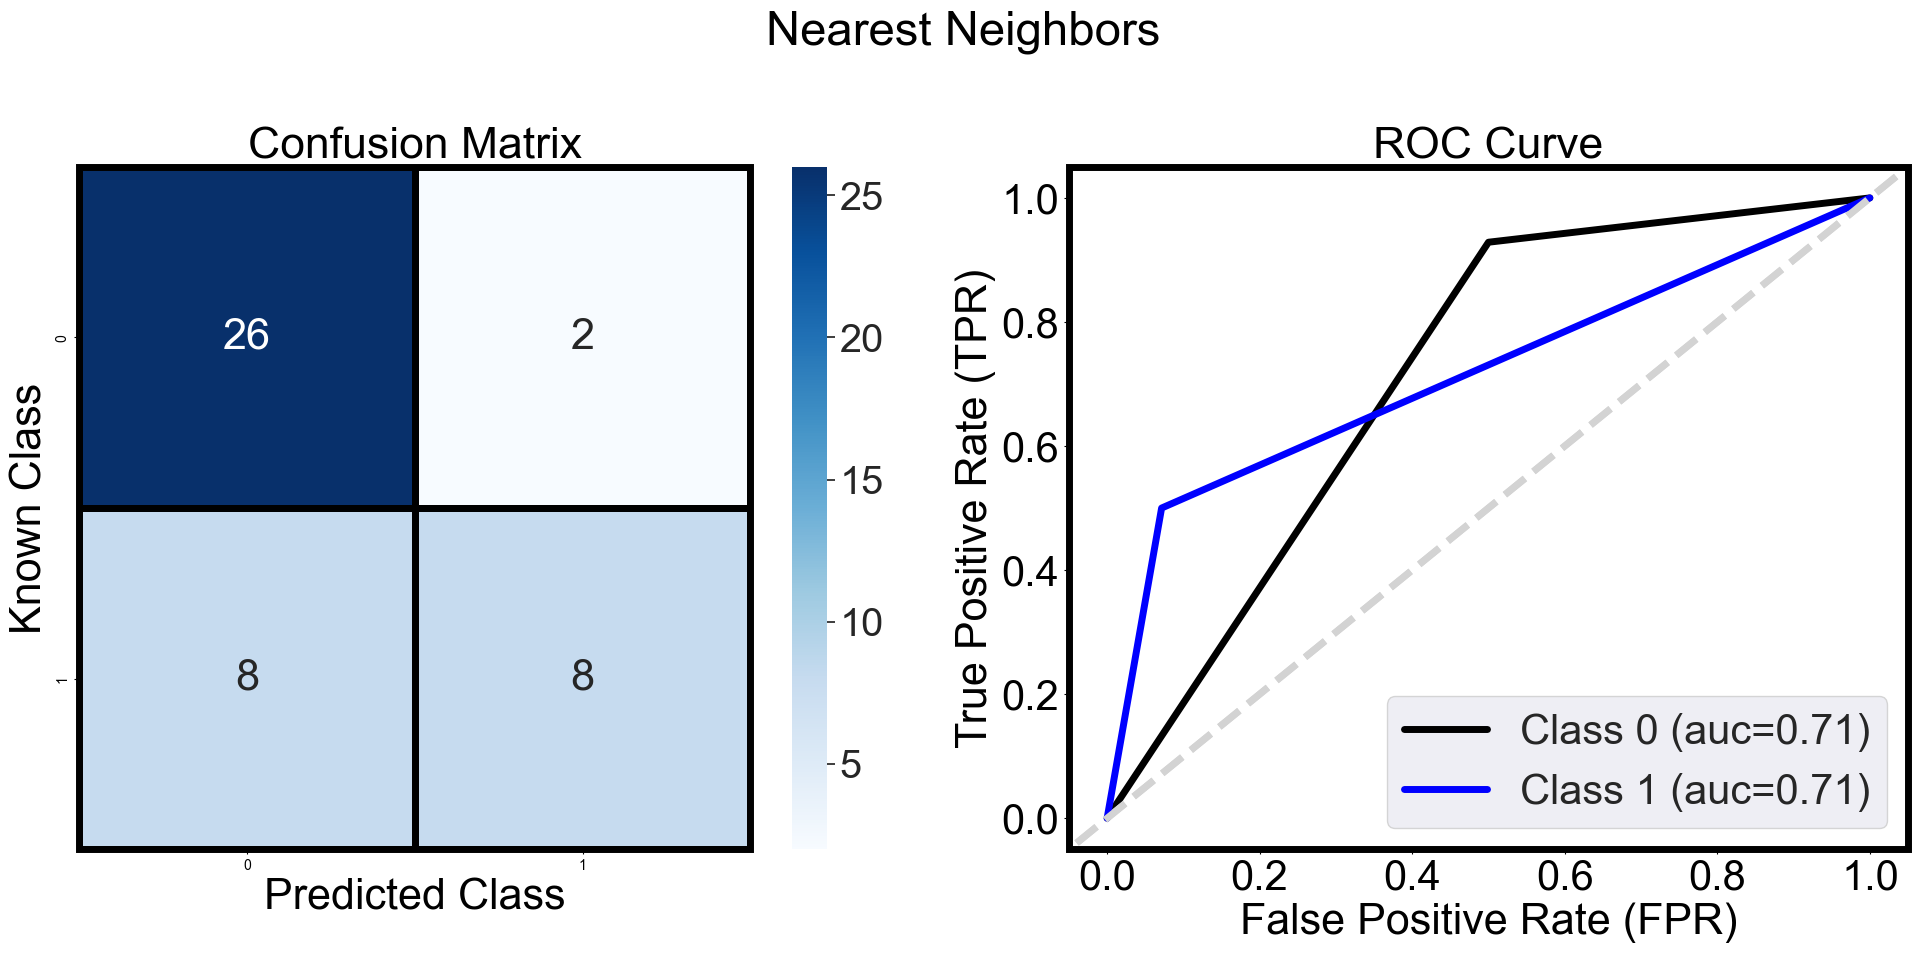

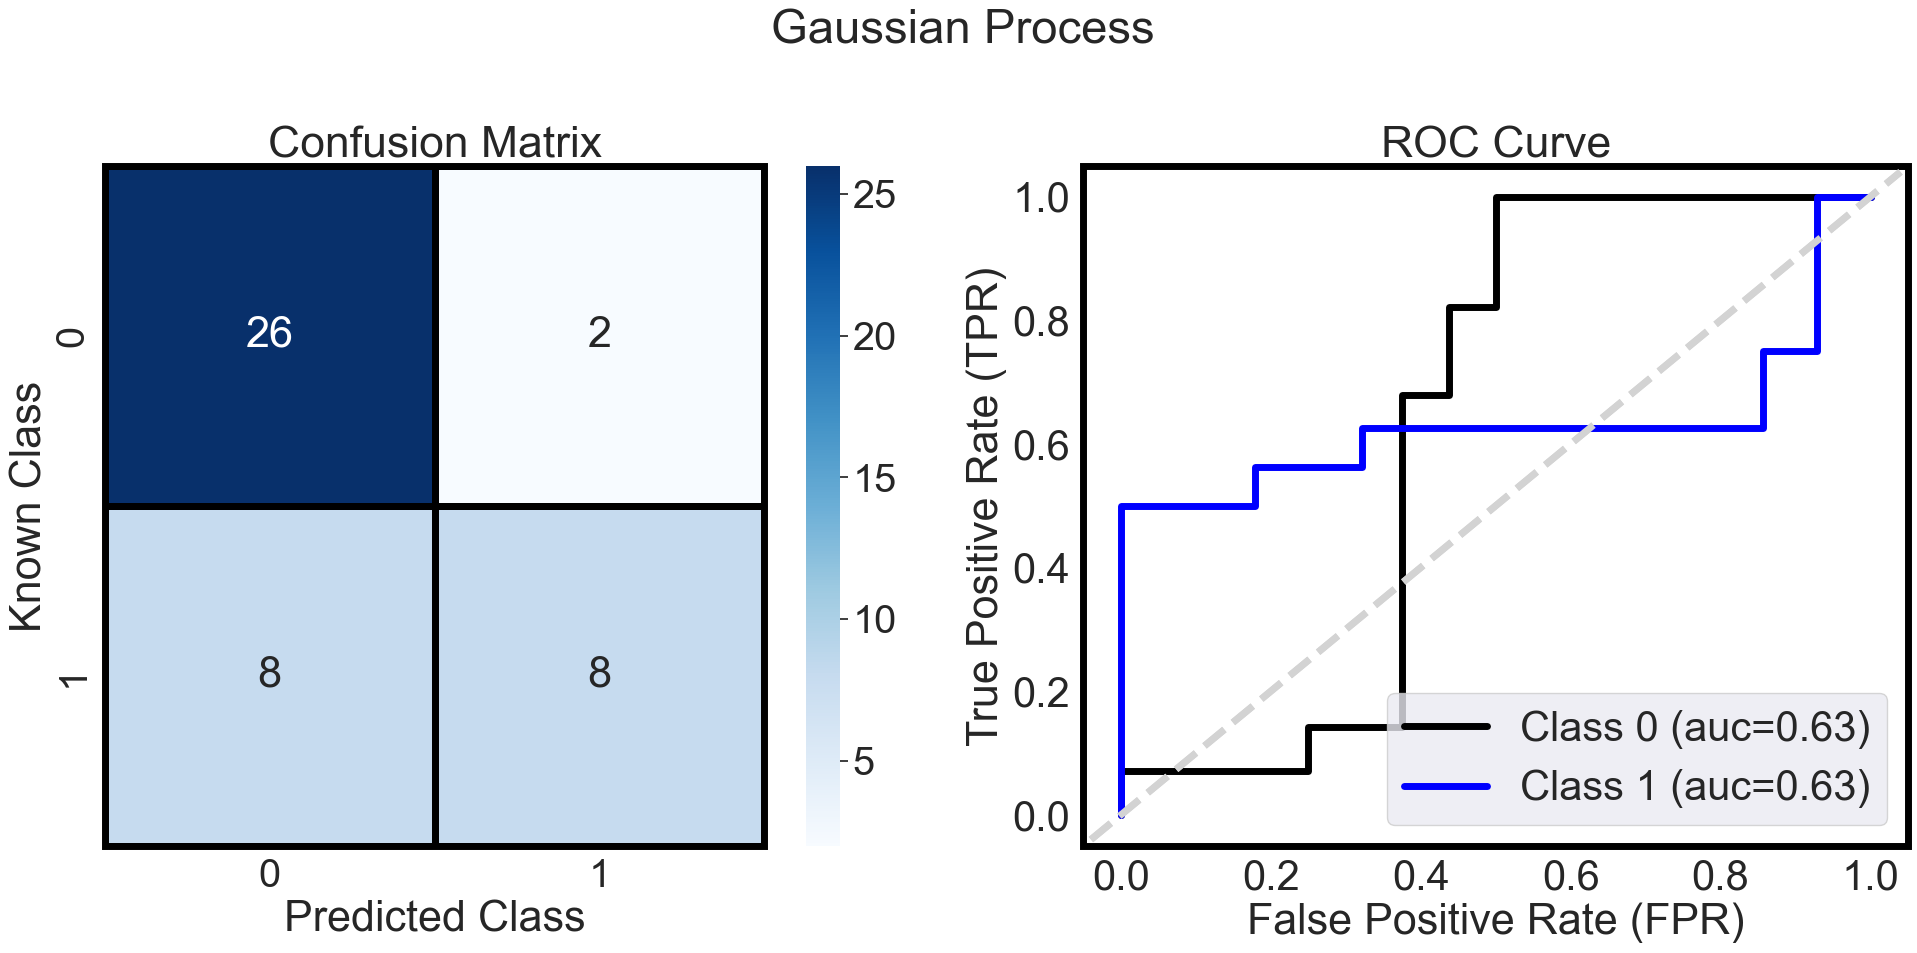

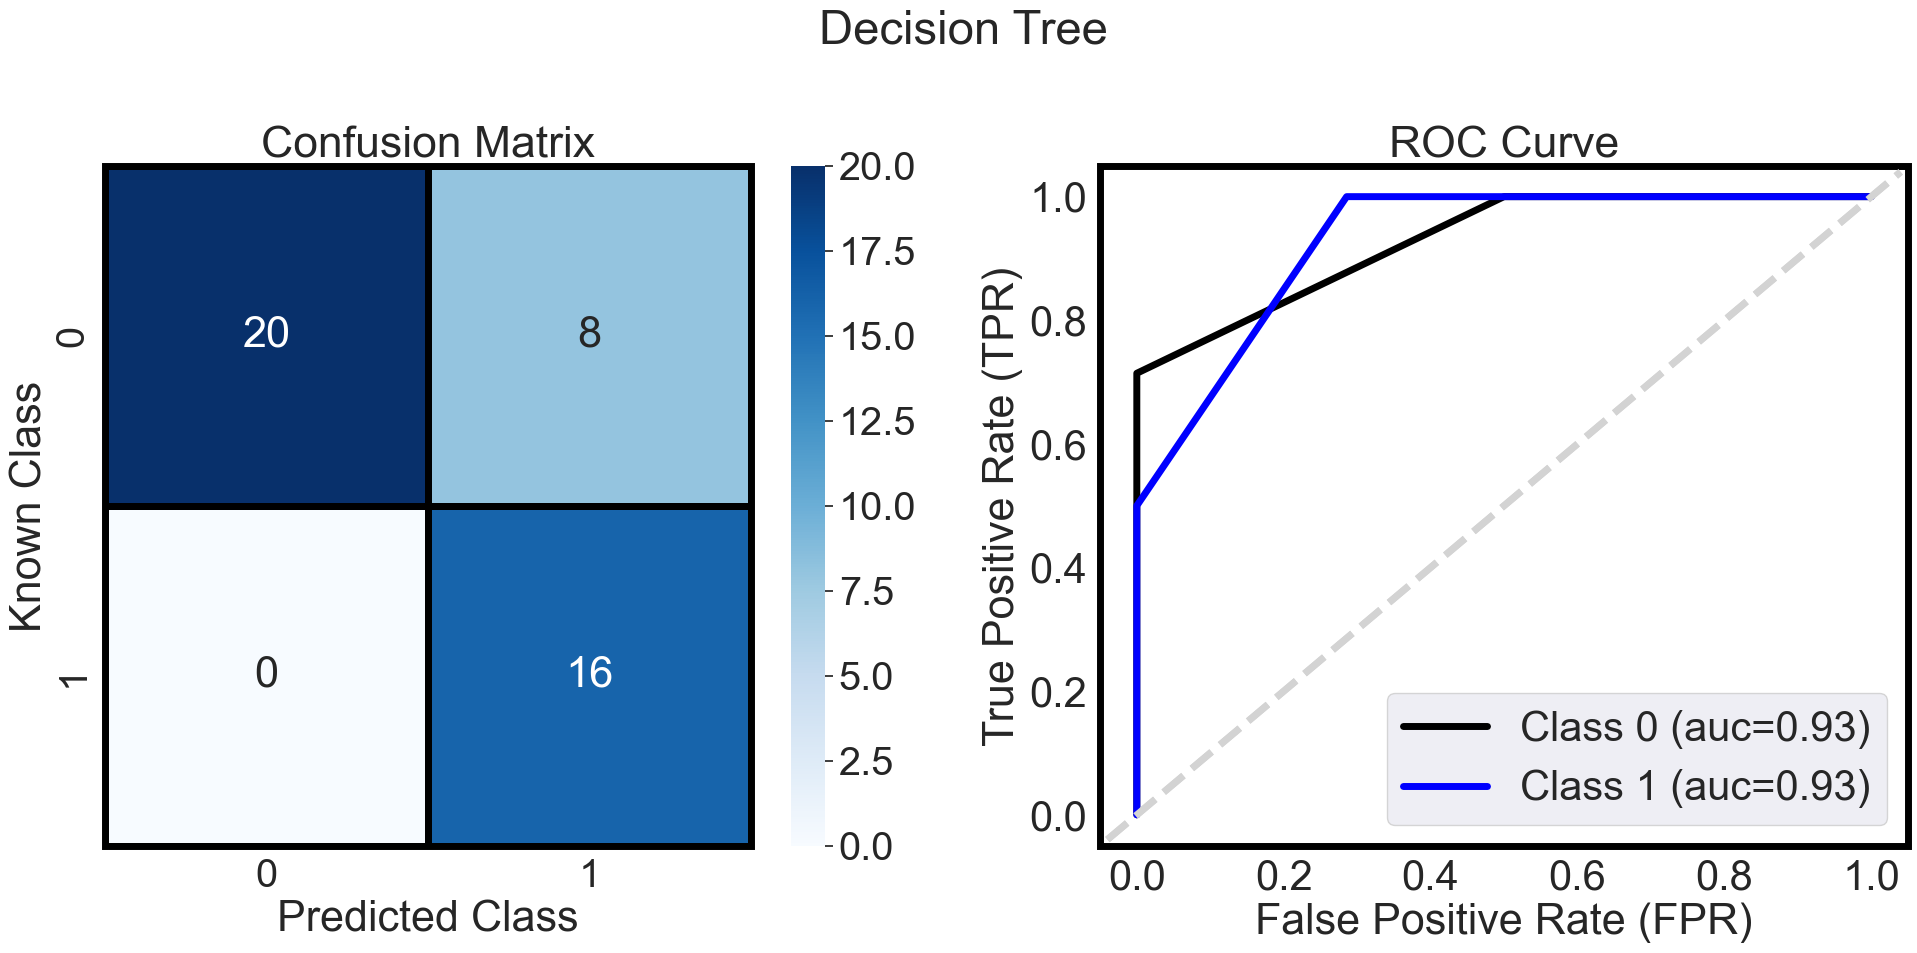

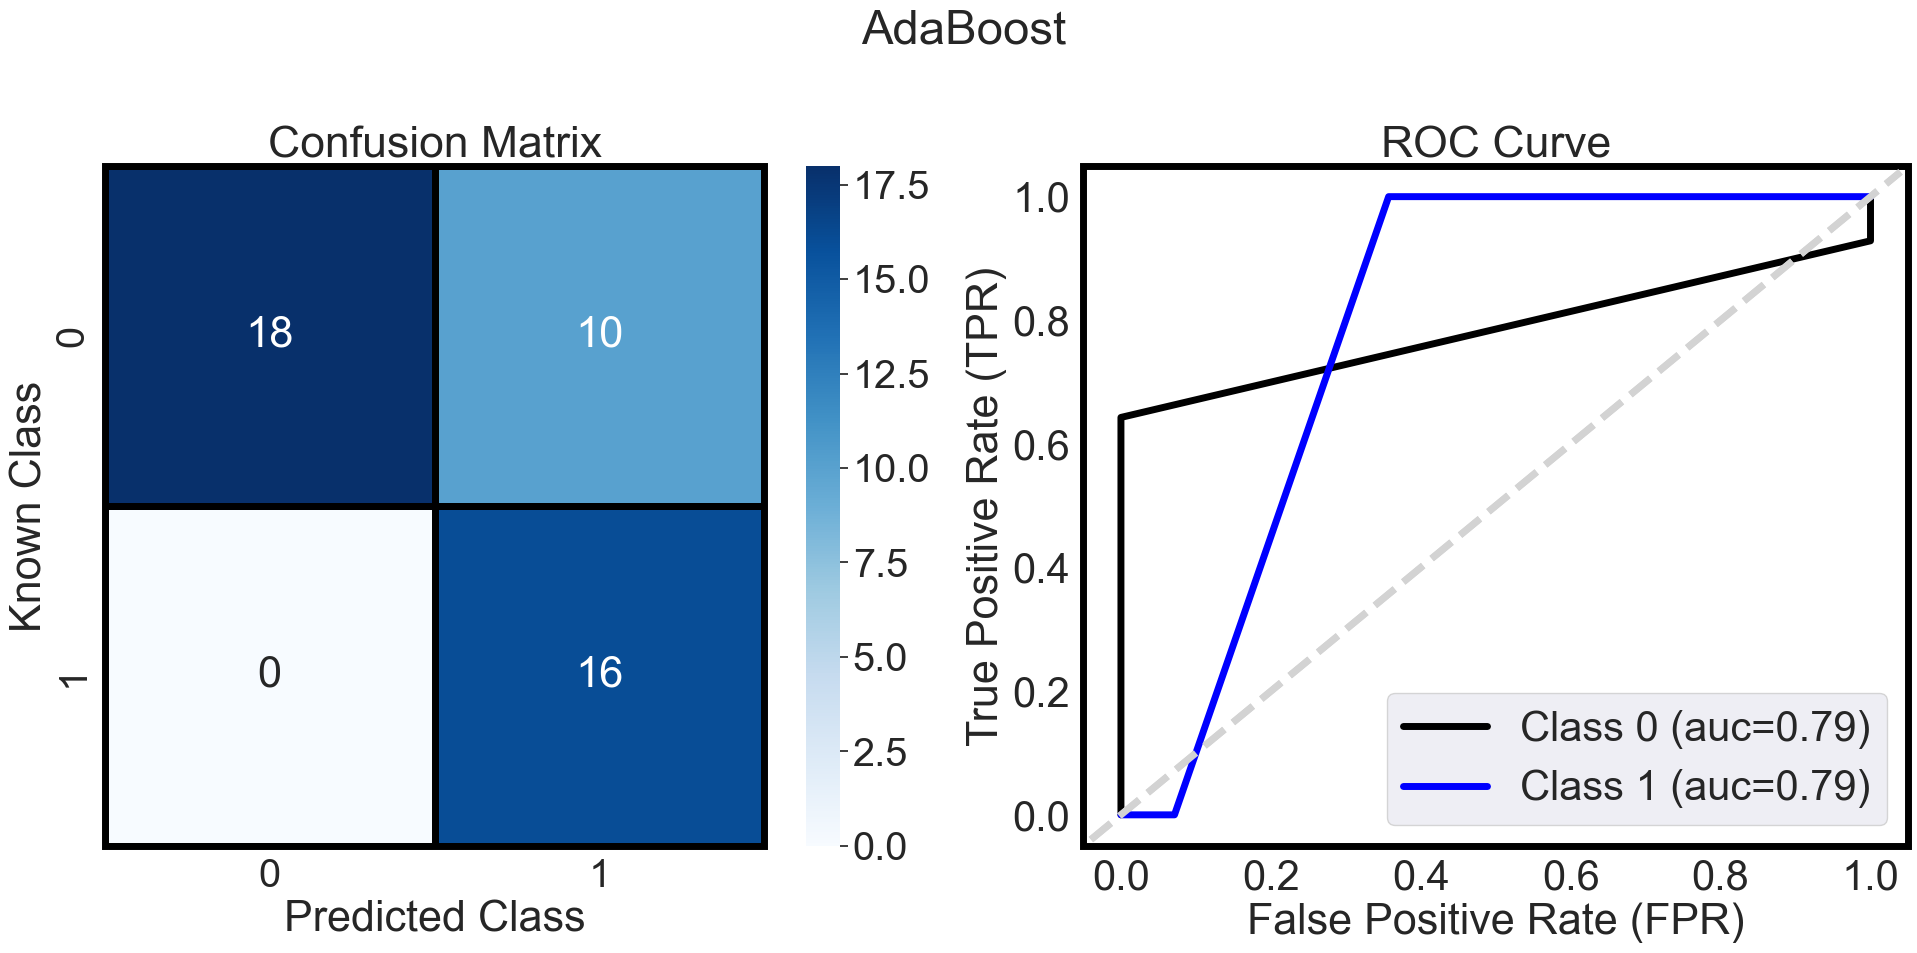

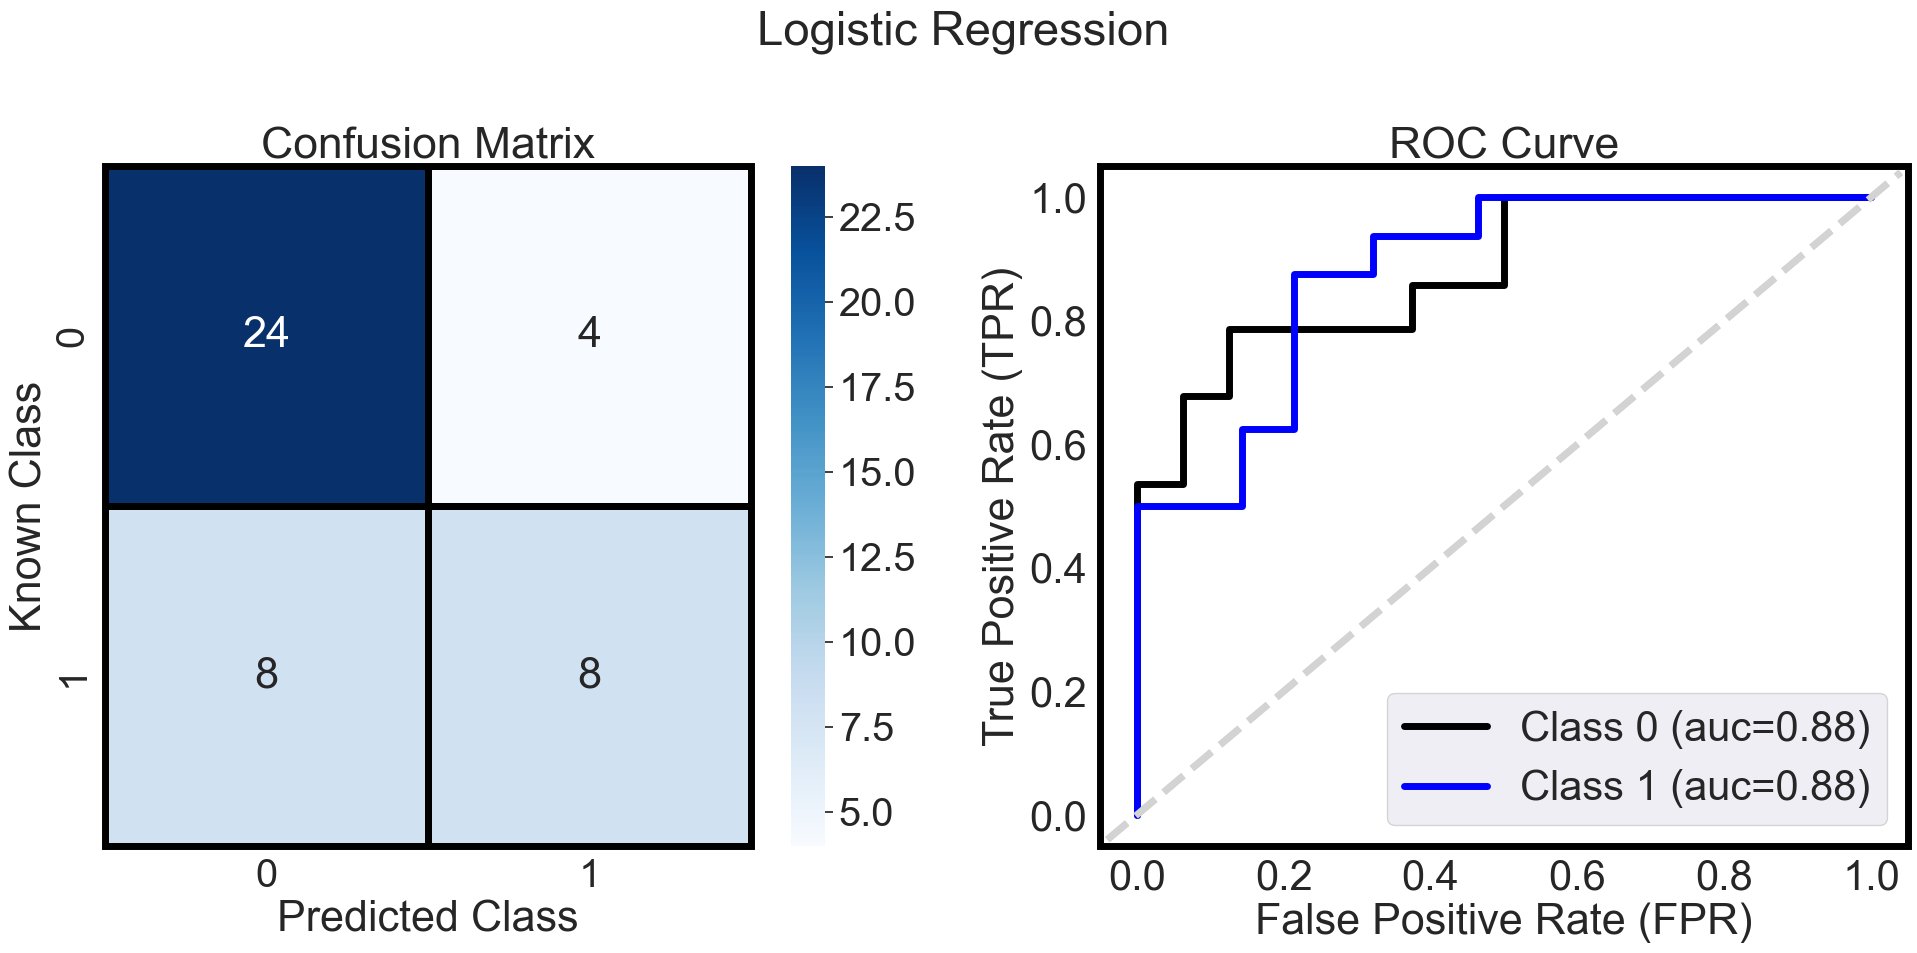

In [52]:
files_plt = []

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = cwf.build_data_from_directory(dirname, max_folds=1, save=True)
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.debug("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.debug("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "fig_MLtestset_{}.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="Blues", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))
    
    metrics_for_paper = {
    "Accuracy": metrics["accuracy"].round(2),
    "Sensitivity": metrics["tpr"].round(2),
    "Specificity": metrics["tnr"].round(2),
    "MCC": metrics["matthews_correlation_coefficient"].round(2),
    "Precision": metrics["precision"].round(2),
    "G-mean": metrics["g-mean"].round(2),
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_mordred.tex", "w") as fout:
    cap = "Classifier metrics for balanced data. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:mordred_features")
log.info(df_metrics_for_paper.to_latex())

In [53]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("fig_MLtestset_combined.png")

Combining 5 images
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
New image will be W:6000 H:15000
Image 0 added at offset height 0
Image 1 added at offset height 3000
Image 2 added at offset height 6000
Image 3 added at offset height 9000
Image 4 added at offset height 12000


# Analysis

## Load best model

In [54]:
model_file = 'model_Decision_Tree.sav'

In [55]:
# Combine the training and test set for some analysis
X = pd.concat([Xtrain, Xtest])
Y = np.concatenate((Ytrain.classes.tolist(), Ytest), axis=0)

### Permutation feature importance

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

In [56]:
help(cmetrics.calculate_permutation_importance)

Help on function calculate_permutation_importance in module pythia.classification_metrics:

calculate_permutation_importance(model_file, x, y, n_repeats=5, n_toplot=7, save=True, random_seed=None, filename='test', figsize=(9, 9), fontsize=30, color='lightgrey', error_color='darkgrey')
    Calculate the permutation importance of the features of a model.
    Parameters:
    model_file: the name of the model .sav file
    x: the features
    y: the target
    n_repeats: the number of times to repeat the permutation. Default is 5.
    n_toplot: the number of features to plot. Default is 7.
    save: whether to save the plot. Default is True.
    random_seed: the random seed. Default is None.
    
    Returns:
    df: the dataframe of feature importance



on all set
Decision Tree


,feature,importance,importance_std,abs_importance
0,BCUTc-1h,0.183114,0.008634,0.183114
1,PEOE_VSA12,0.062500,0.002686,0.062500
2,fp_107,0.061404,0.015507,0.061404
3,fp_97,0.049342,0.007106,0.049342
4,fp_149,0.048246,0.006759,0.048246
...,...,...,...,...
136,fp_69,0.000000,0.000000,0.000000
137,fp_67,0.000000,0.000000,0.000000
138,fp_66,0.000000,0.000000,0.000000
139,fp_65,0.000000,0.000000,0.000000


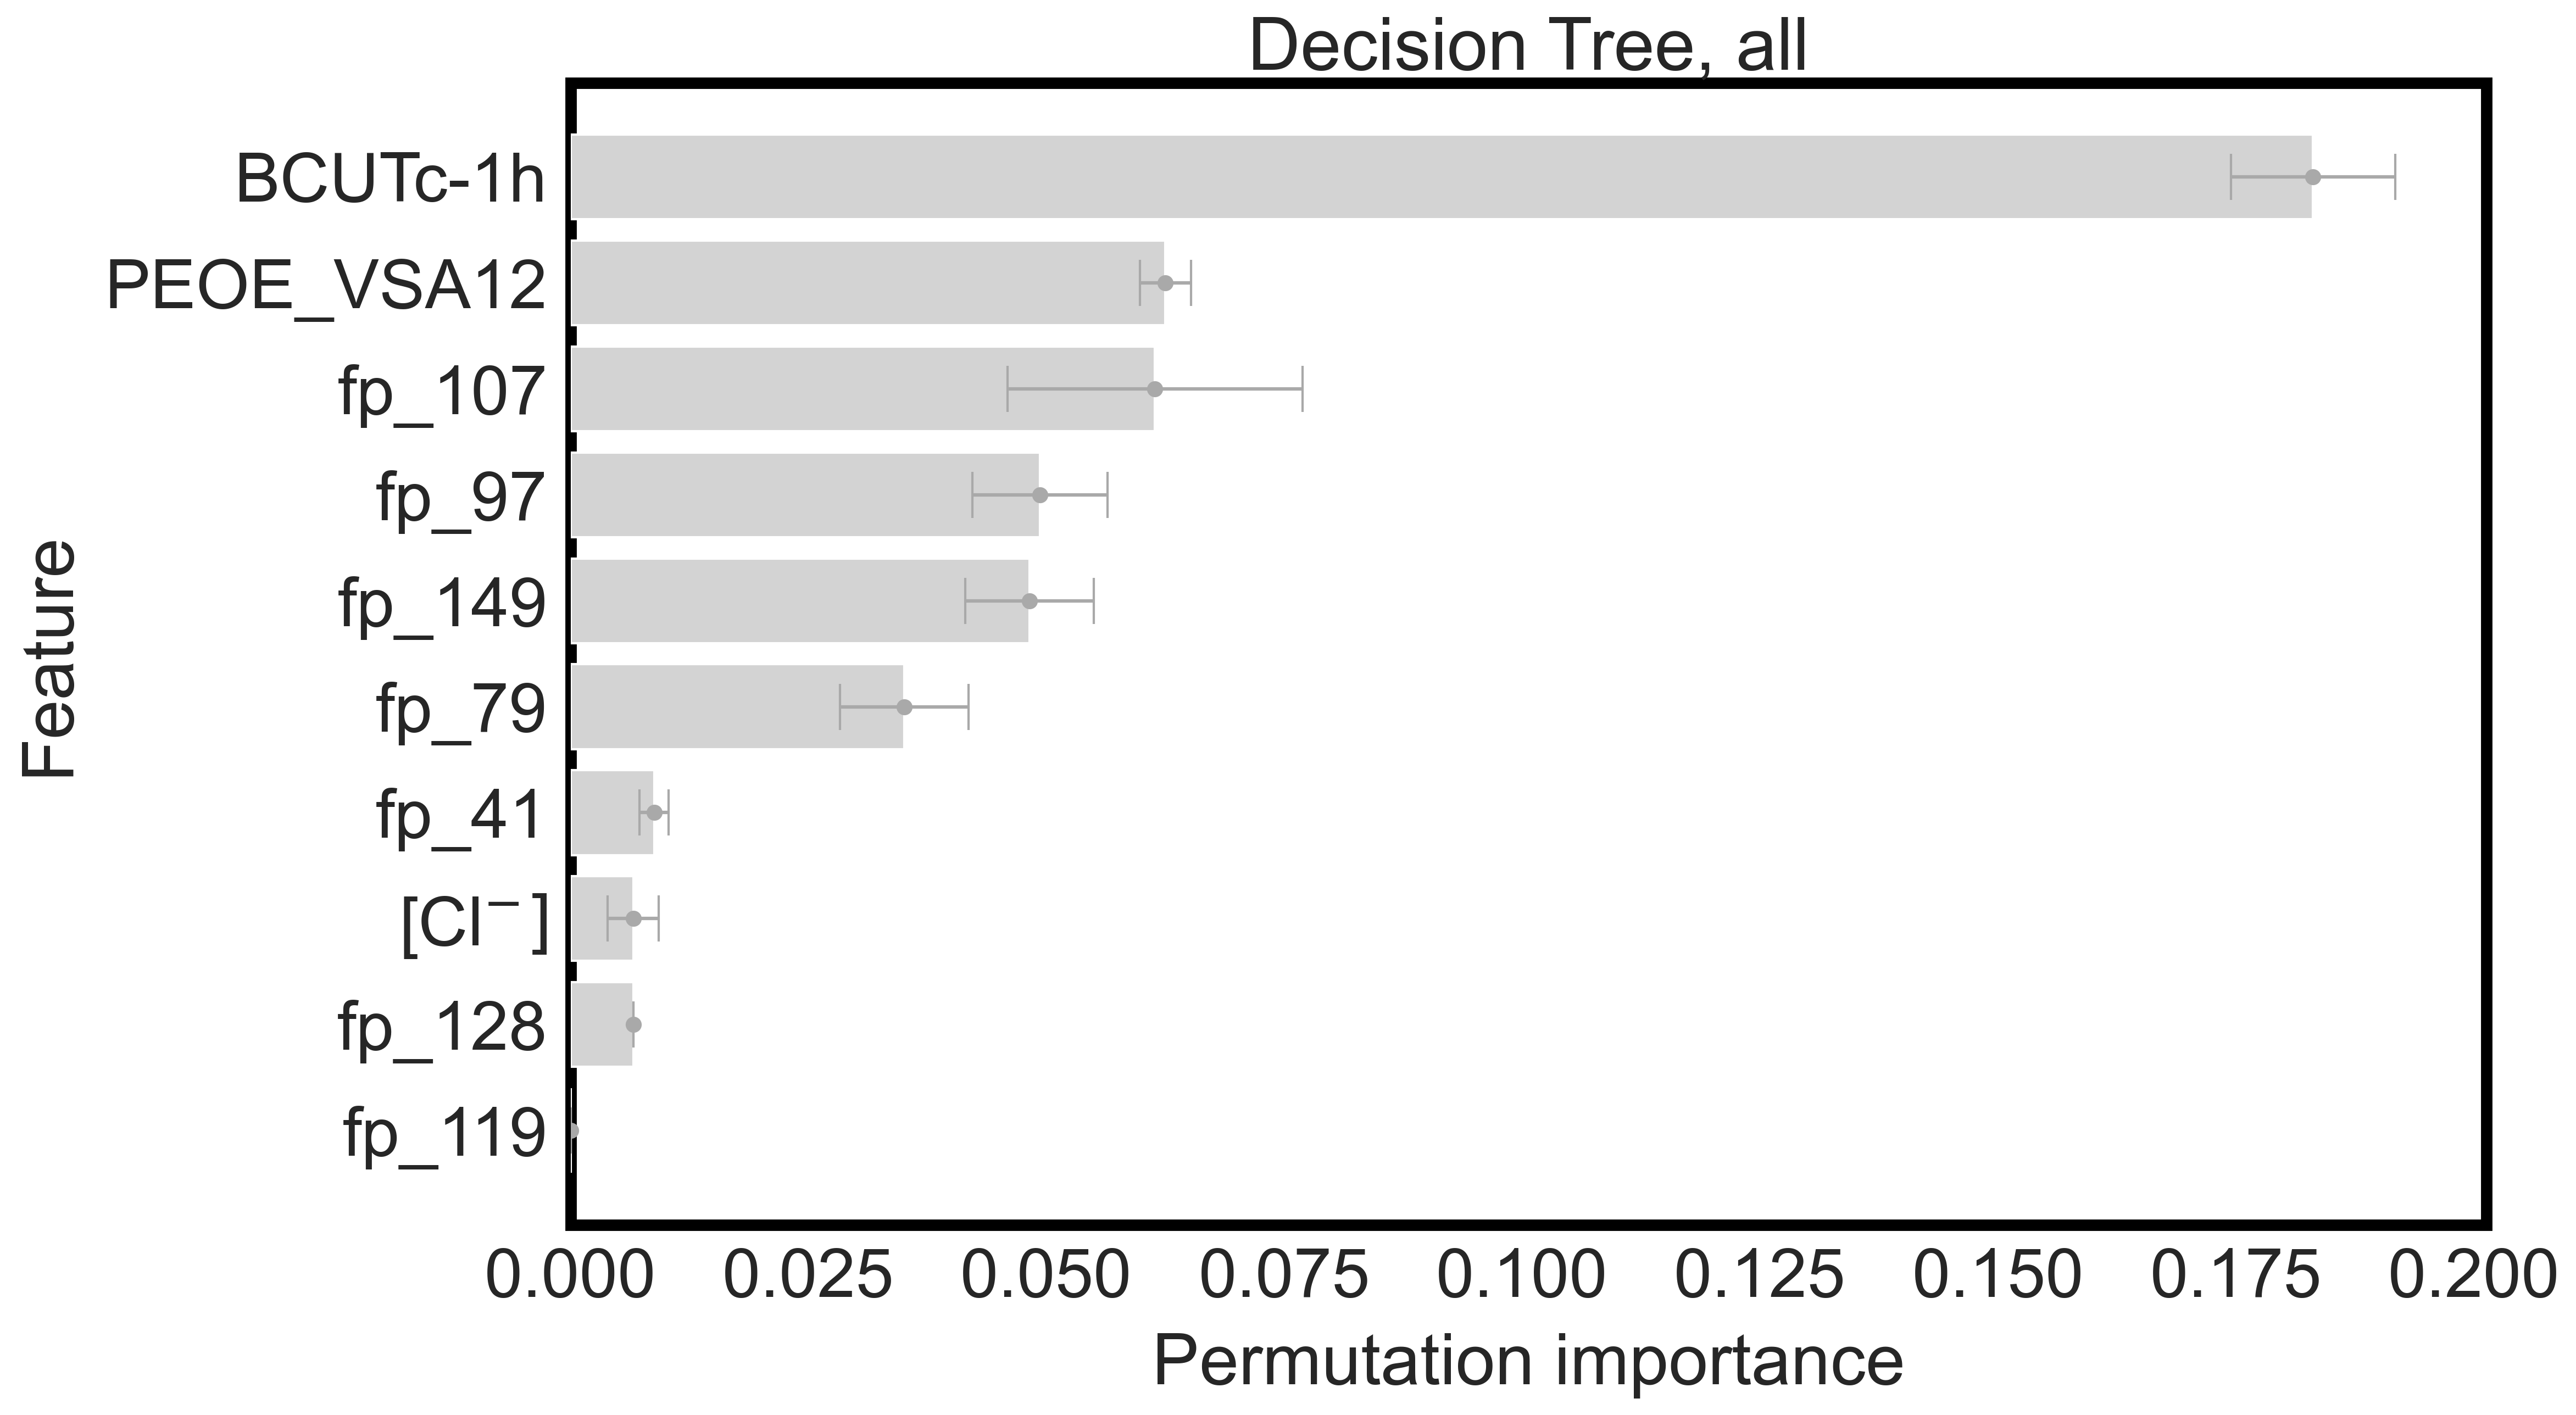

In [57]:
print("on all set")
cmetrics.calculate_permutation_importance(model_file, x=X, y=Y, filename='all',fontsize=30, figsize=(15,9), n_repeats=3, n_toplot=10)

### sklearn feature importance

Obtain the feature importance from the best model using the ***cwf.sklearn_feature_importance*** function.

In [58]:
model_name = model_file.split(".")[0].replace("model_", "")
print(model_name)
clf_model = joblib.load(model_file)

importances = clf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features_names = Xtrain.columns
features = []
for a in features_names:
    if str(a).startswith("time_between_transporter_added_and_lysis_(s)"):
        a= str(a).replace("time_between_transporter_added_and_lysis_(s)","$\Delta t$")
    if str(a).startswith("cl_conc_(mm)"):
        a= str(a).replace("cl_conc_(mm)", "[Cl$^{-}]$")
    features.append(str(a))
# create a list of feature names and their importance
feature_importance = []
for f in range(Xtrain.shape[1]):
    feature_importance.append((features[indices[f]], importances[indices[f]]))
df_feature_importance = pd.DataFrame(feature_importance, columns=["feature", "importance"])
df_feature_importance['importance_abs'] = df_feature_importance['importance'].abs()
df_feature_importance = df_feature_importance.sort_values(by='importance_abs', ascending=False)

Decision_Tree


In [59]:
df_feature_importance

,feature,importance,importance_abs
0,BCUTc-1h,0.474330,0.474330
1,PEOE_VSA12,0.104257,0.104257
2,fp_97,0.091587,0.091587
3,fp_107,0.091262,0.091262
4,fp_79,0.084359,0.084359
...,...,...,...
46,NdsCH_1,0.000000,0.000000
45,NdsCH_0,0.000000,0.000000
44,nBase_1,0.000000,0.000000
43,nBase_0,0.000000,0.000000


Plot the feature importance as a bar plot

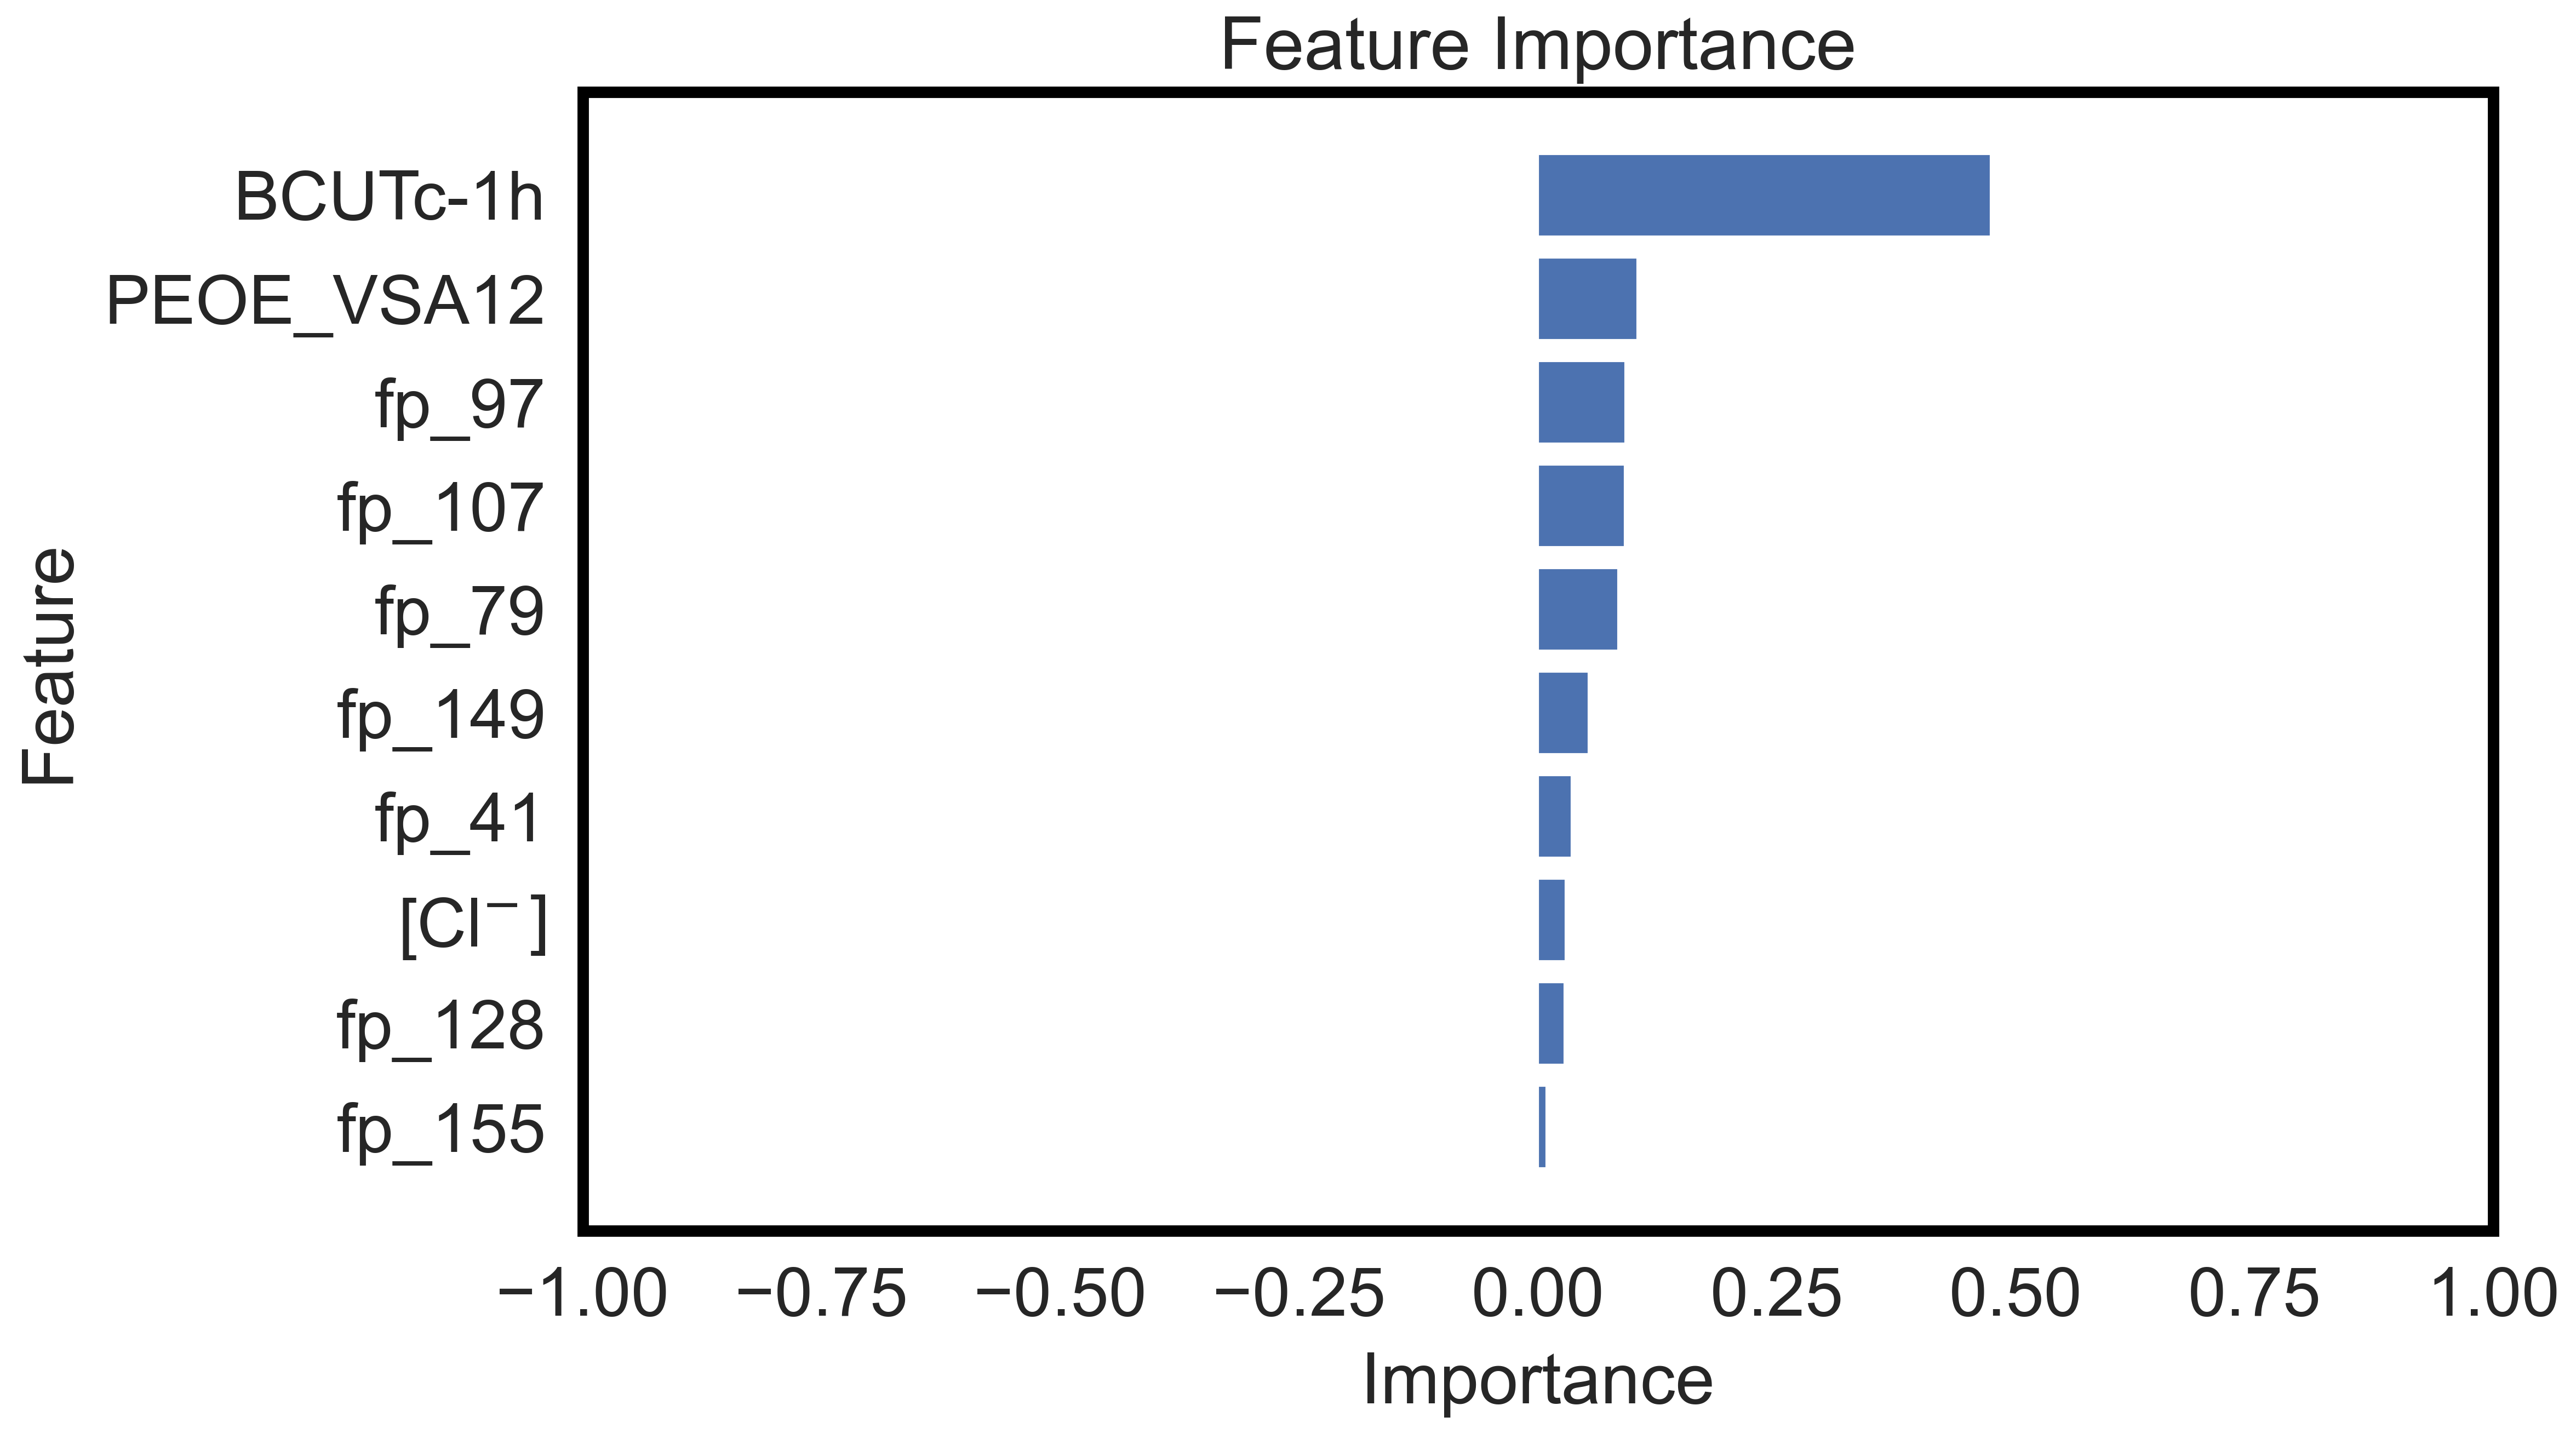

In [60]:
# plot the N most important features
N = 10
fontsize = 30

fig, axes = plt.subplots(figsize=(15,9), dpi=300)
axes.barh(df_feature_importance['feature'][:N], df_feature_importance['importance'][:N], align='center')
axes.set_ylim([-1, N])
axes.set_xlim([-1, 1])
axes.set_xlabel('Importance', fontsize=fontsize+1, labelpad=10)
axes.set_ylabel('Feature', fontsize=fontsize+1, labelpad=10)
axes.tick_params(labelsize=fontsize)
axes.grid(False)
axes.set_title('Feature Importance', fontsize=fontsize+2, pad=10)

axes.invert_yaxis()
axes.patch.set_facecolor('white')
axes.patch.set_edgecolor('black')
axes.patch.set_linewidth(5)
axes.tick_params(pad=10)

for _, spine in axes.spines.items():
    spine.set_visible(False)

fig.savefig("fig_feature_importance_{}.png".format(model_name), dpi=300)

## SHAP analysis

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

In [61]:
# load model from .sav file
model_file = "model_Decision_Tree.sav"
model_name = model_file.split(".")[0].split("finalized_MLmodel_")[-1]
clf_shap = joblib.load(model_file)

#explaining model
explainer = shap.TreeExplainer(clf_shap, X)

shap_values = explainer.shap_values(X)

In [62]:
# update the feature names for plotting
feature_names = []
for a,b in zip(X.columns, np.abs(shap_values).mean(0).round(2)):
    if a == "time_between_transporter_added_and_lysis_(s)":
        a = "$\Delta t$"
    if a == "cl_conc_(mm)":
        a = "[Cl$^{-}]$"
    feature_names.append(str(a))

Here we calculate the SHAP summary plot for the best model. SHAP values represent a feature's responsibility for a change in the model output. The SHAP summary plot provides a birds-eye view of feature importance and what is driving the model's predictions.

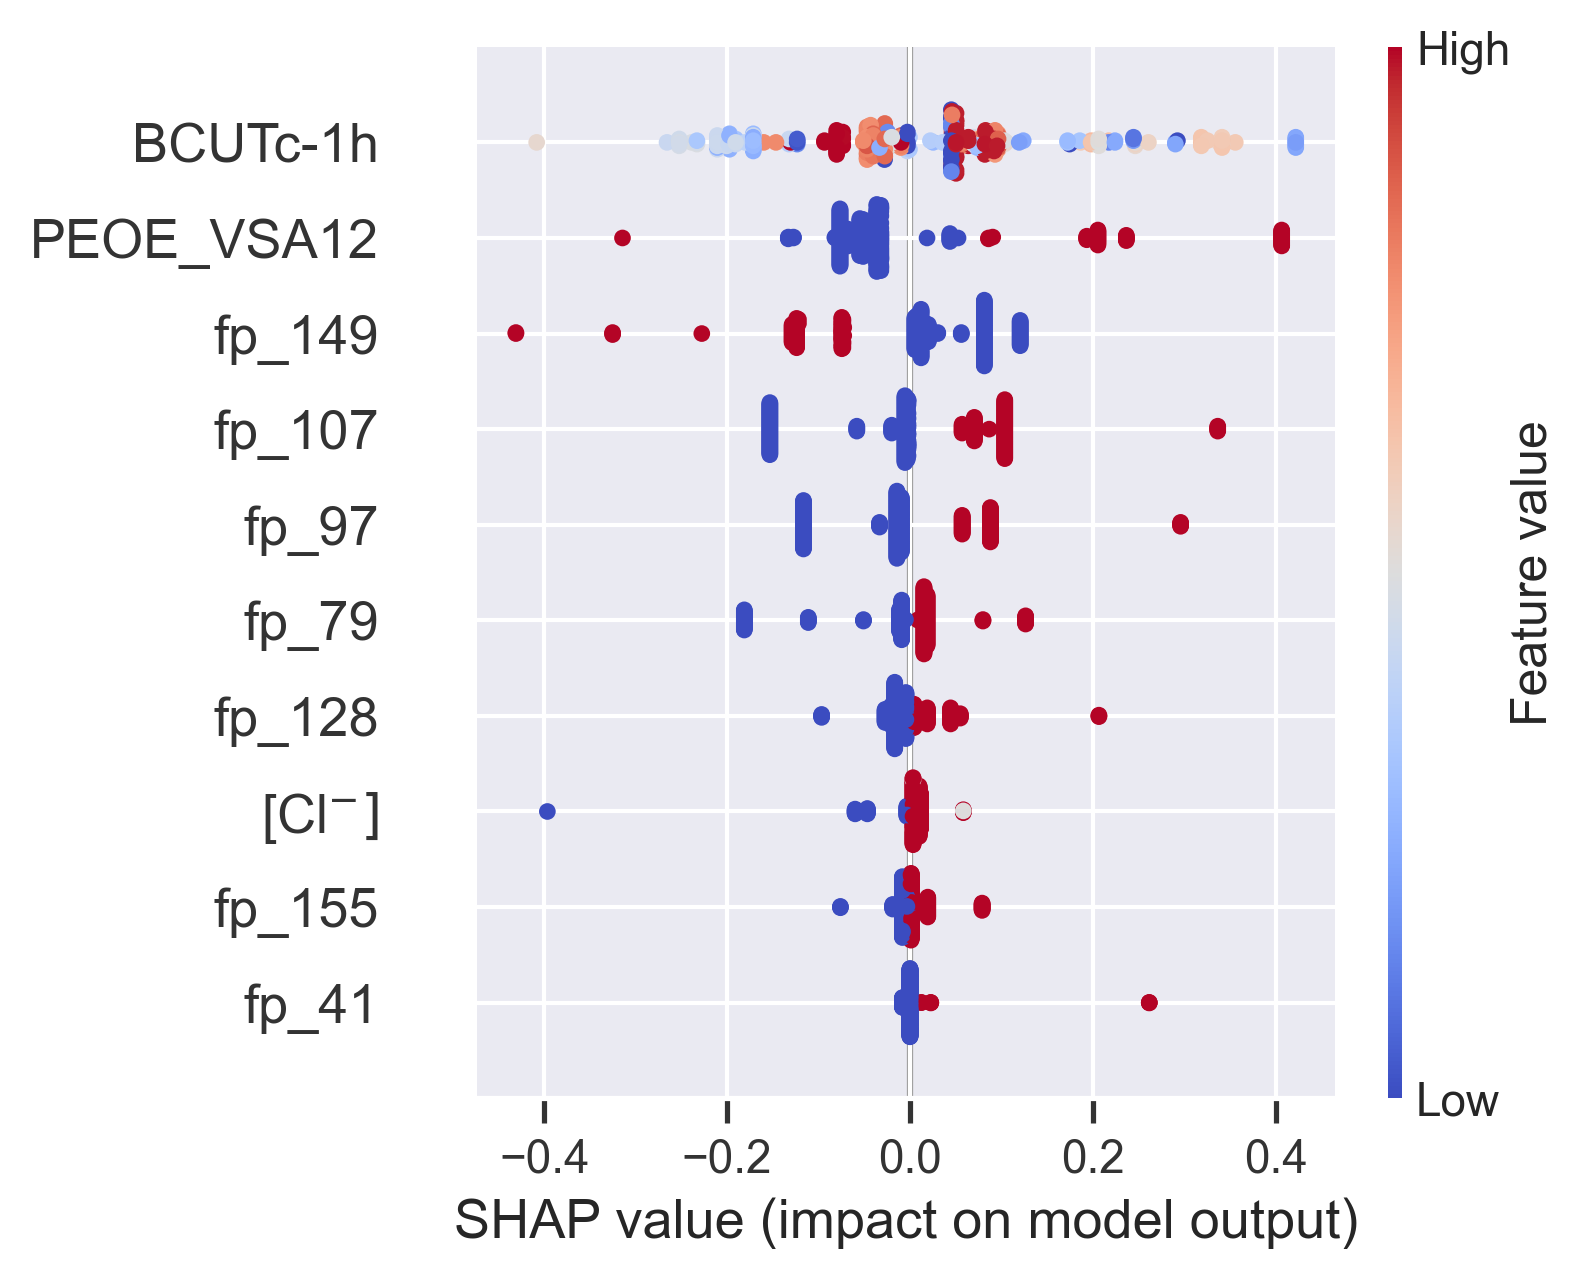

In [63]:
# SHAP summary plot
fig = plt.figure(figsize=(6, 5), dpi=300)
fig.set_facecolor('white')
cmap = sns.color_palette("coolwarm", as_cmap=True)

# plot the summary plot for class 1
shap.summary_plot(shap_values[1], X, max_display=10, cmap=cmap, show=False, feature_names=feature_names)

plt.gcf().set_size_inches(6,5)
fig.tight_layout()
fig.savefig("shap_summary_plot_{}_X.png".format(model_name), dpi=300)
plt.show()

# Visualize the MACCS key

MACCS keys are a set of 166 keys that are used to encode the presence or absence of certain substructures in a molecule. The keys are binary, i.e. a key is either present or absent in a molecule.

Here we copied the MACCS keys available in RDKit to visualize the presence of the important MACCS keys in the dataset.

In [64]:
smartsPatts = {
    1: ('?', 0, 'ISOTOPE'),  
    2: ('[#104]', 0, 'limit the above def\'n since the RDKit only accepts up to #104'),
    3: ('[#32,#33,#34,#50,#51,#52,#82,#83,#84]', 0, 'Group IVa,Va,VIa Rows 4-6'), 
    4: ('[Ac,Th,Pa,U,Np,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr]', 0, 'actinide'),
    5: ('[Sc,Ti,Y,Zr,Hf]', 0, 'Group IIIB,IVB (Sc...)'),
    6: ('[La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu]', 0, 'Lanthanide'),
    7: ('[V,Cr,Mn,Nb,Mo,Tc,Ta,W,Re]', 0, 'Group VB,VIB,VIIB'),
    8: ('[!#6;!#1]1~*~*~*~1', 0, 'QAAA@1'),
    9: ('[Fe,Co,Ni,Ru,Rh,Pd,Os,Ir,Pt]', 0, 'Group VIII (Fe...)'),
    10: ('[Be,Mg,Ca,Sr,Ba,Ra]', 0, 'Group IIa (Alkaline earth)'),
    11: ('*1~*~*~*~1', 0, '4M Ring'),
    12: ('[Cu,Zn,Ag,Cd,Au,Hg]', 0, 'Group IB,IIB (Cu..)'),
    13: ('[#8]~[#7](~[#6])~[#6]', 0, 'ON(C)C'),
    14: ('[#16]-[#16]', 0, 'S-S'),
    15: ('[#8]~[#6](~[#8])~[#8]', 0, 'OC(O)O'),
    16: ('[!#6;!#1]1~*~*~1', 0, 'QAA@1'),
    17: ('[#6]#[#6]', 0, 'CTC'),
    18: ('[#5,#13,#31,#49,#81]', 0, 'Group IIIA (B...)'),
    19: ('*1~*~*~*~*~*~*~1', 0, '7M Ring'),
    20: ('[#14]', 0, 'Si'),
    21: ('[#6]=[#6](~[!#6;!#1])~[!#6;!#1]', 0, 'C=C(Q)Q'),
    22: ('*1~*~*~1', 0, '3M Ring'),
    23: ('[#7]~[#6](~[#8])~[#8]', 0, 'NC(O)O'),
    24: ('[#7]-[#8]', 0, 'N-O'),
    25: ('[#7]~[#6](~[#7])~[#7]', 0, 'NC(N)N'),
    26: ('[#6]=;@[#6](@*)@*', 0, 'C$=C($A)$A'),
    27: ('[I]', 0, 'I'),
    28: ('[!#6;!#1]~[CH2]~[!#6;!#1]', 0, 'QCH2Q'),
    29: ('[#15]', 0, 'P'),
    30: ('[#6]~[!#6;!#1](~[#6])(~[#6])~*', 0, 'CQ(C)(C)A'),
    31: ('[!#6;!#1]~[F,Cl,Br,I]', 0, 'QX'),
    32: ('[#6]~[#16]~[#7]', 0, 'CSN'),
    33: ('[#7]~[#16]', 0, 'NS'),
    34: ('[CH2]=*', 0, 'CH2=A'),
    35: ('[Li,Na,K,Rb,Cs,Fr]', 0, 'Group IA (Alkali Metal)'),
    36: ('[#16R]', 0, 'S Heterocycle'),
    37: ('[#7]~[#6](~[#8])~[#7]', 0, 'NC(O)N'),
    38: ('[#7]~[#6](~[#6])~[#7]', 0, 'NC(C)N'),
    39: ('[#8]~[#16](~[#8])~[#8]', 0, 'OS(O)O'),
    40: ('[#16]-[#8]', 0, 'S-O'),
    41: ('[#6]#[#7]', 0, 'CTN'),
    42: ('F', 0, 'F'),
    43: ('[!#6;!#1;!H0]~*~[!#6;!#1;!H0]', 0, 'QHAQH'),
    44: ('[!#1;!#6;!#7;!#8;!#9;!#14;!#15;!#16;!#17;!#35;!#53]', 0, 'OTHER'),
    45: ('[#6]=[#6]~[#7]', 0, 'C=CN'),
    46: ('Br', 0, 'BR'),
    47: ('[#16]~*~[#7]', 0, 'SAN'),
    48: ('[#8]~[!#6;!#1](~[#8])(~[#8])', 0, 'OQ(O)O'),
    49: ('[!+0]', 0, 'CHARGE'),
    50: ('[#6]=[#6](~[#6])~[#6]', 0, 'C=C(C)C'),
    51: ('[#6]~[#16]~[#8]', 0, 'CSO'),
    52: ('[#7]~[#7]', 0, 'NN'),
    53: ('[!#6;!#1;!H0]~*~*~*~[!#6;!#1;!H0]', 0, 'QHAAAQH'),
    54: ('[!#6;!#1;!H0]~*~*~[!#6;!#1;!H0]', 0, 'QHAAQH'),
    55: ('[#8]~[#16]~[#8]', 0, 'OSO'),
    56: ('[#8]~[#7](~[#8])~[#6]', 0, 'ON(O)C'),
    57: ('[#8R]', 0, 'O Heterocycle'),
    58: ('[!#6;!#1]~[#16]~[!#6;!#1]', 0, 'QSQ'),
    59: ('[#16]!:*:*', 0, 'Snot%A%A'),
    60: ('[#16]=[#8]', 0, 'S=O'),
    61: ('*~[#16](~*)~*', 0, 'AS(A)A'),
    62: ('*@*!@*@*', 0, 'A$!A$A'),
    63: ('[#7]=[#8]', 0, 'N=O'),
    64: ('*@*!@[#16]', 0, 'A$A!S'),
    65: ('c:n', 0, 'C%N'),
    66: ('[#6]~[#6](~[#6])(~[#6])~*', 0, 'CC(C)(C)A'),
    67: ('[!#6;!#1]~[#16]', 0, 'QS'),
    68: ('[!#6;!#1;!H0]~[!#6;!#1;!H0]', 0, 'QHQH (&...) SPEC Incomplete'),
    69: ('[!#6;!#1]~[!#6;!#1;!H0]', 0, 'QQH'),
    70: ('[!#6;!#1]~[#7]~[!#6;!#1]', 0, 'QNQ'),
    71: ('[#7]~[#8]', 0, 'NO'),
    72: ('[#8]~*~*~[#8]', 0, 'OAAO'),
    73: ('[#16]=*', 0, 'S=A'),
    74: ('[CH3]~*~[CH3]', 0, 'CH3ACH3'),
    75: ('*!@[#7]@*', 0, 'A!N$A'),
    76: ('[#6]=[#6](~*)~*', 0, 'C=C(A)A'),
    77: ('[#7]~*~[#7]', 0, 'NAN'),
    78: ('[#6]=[#7]', 0, 'C=N'),
    79: ('[#7]~*~*~[#7]', 0, 'NAAN'),
    80: ('[#7]~*~*~*~[#7]', 0, 'NAAAN'),
    81: ('[#16]~*(~*)~*', 0, 'SA(A)A'),
    82: ('*~[CH2]~[!#6;!#1;!H0]', 0, 'ACH2QH'),
    83: ('[!#6;!#1]1~*~*~*~*~1', 0, 'QAAAA@1'),
    84: ('[NH2]', 0, 'NH2'),
    85: ('[#6]~[#7](~[#6])~[#6]', 0, 'CN(C)C'),
    86: ('[C;H2,H3][!#6;!#1][C;H2,H3]', 0, 'CH2QCH2'),
    87: ('[F,Cl,Br,I]!@*@*', 0, 'X!A$A'),
    88: ('[#16]', 0, 'S'),
    89: ('[#8]~*~*~*~[#8]', 0, 'OAAAO'),
    90: ('[$([!#6;!#1;!H0]~*~*~[CH2]~*),$([!#6;!#1;!H0;R]1@[R]@[R]@[CH2;R]1),$([!#6;!#1;!H0]~[R]1@[R]@[CH2;R]1)]', 0, 'QHAACH2A'),
    91: ('[$([!#6;!#1;!H0]~*~*~*~[CH2]~*),$([!#6;!#1;!H0;R]1@[R]@[R]@[R]@[CH2;R]1),$([!#6;!#1;!H0]~[R]1@[R]@[R]@[CH2;R]1),$([!#6;!#1;!H0]~*~[R]1@[R]@[CH2;R]1)]', 0, 'QHAAACH2A'),
    92: ('[#8]~[#6](~[#7])~[#6]', 0, 'OC(N)C'),
    93: ('[!#6;!#1]~[CH3]', 0, 'QCH3'),
    94: ('[!#6;!#1]~[#7]', 0, 'QN'),
    95: ('[#7]~*~*~[#8]', 0, 'NAAO'),
    96: ('*1~*~*~*~*~1', 0, '5 M ring'),
    97: ('[#7]~*~*~*~[#8]', 0, 'NAAAO'),
    98: ('[!#6;!#1]1~*~*~*~*~*~1', 0, 'QAAAAA@1'),
    99: ('[#6]=[#6]', 0, 'C=C'),
    100: ('*~[CH2]~[#7]', 0, 'ACH2N'),
    101: ('[$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1),$([R]@1@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]@[R]1)]', 0, '8-connected'),
    102: ('[!#6;!#1]~[CH2]~*~*~[CH2]~[!#6;!#1]', 0, 'QCH2AAQCH2Q'),
    103: ('*~[CH2]~*~[CH2]~*', 0, 'ACH2ACH2A'),
    104: ('[!#6;!#1]~[CH2]~*~*~[CH2]~[!#6;!#1]', 0, 'QCH2AAQCH2Q'),
        105: ('*@*!@[#16]', 0, 'A$A!S'),
    106: ('[!#6;!#1]~*(~[!#6;!#1])~[!#6;!#1]', 0, 'QA(Q)Q'),
    107: ('[F,Cl,Br,I]~*(~*)~*', 0, 'XA(A)A'),
    108: ('[CH3]~*~*~*~[CH2]~*', 0, 'CH3AAACH2A'),
    109: ('*~[CH2]~[#8]', 0, 'ACH2O'),
    110: ('[#7]~[#6]~[#8]', 0, 'NCO'),
    111: ('[#7]~*~[CH2]~*', 0, 'NACH2A'),
    112: ('*~*(~*)(~*)~*', 0, 'AA(A)(A)A'),
    113: ('[#8]!:*:*', 0, 'Onot%A%A'),
    114: ('[CH3]~[CH2]~*', 0, 'CH3CH2A'),
    115: ('[CH3]~*~[CH2]~*', 0, 'CH3ACH2A'),
    116: ('[$([CH3]~*~*~[CH2]~*),$([CH3]~*1~*~[CH2]1)]', 0, 'CH3AACH2A'),
    117: ('[#7]~*~[#8]', 0, 'NAO'),
    118: ('[$(*~[CH2]~[CH2]~*),$(*1~[CH2]~[CH2]1)]', 1, 'ACH2CH2A > 1'),
    119: ('[#7]=*', 0, 'N=A'),
    120: ('[!#6;R]', 1, 'Heterocyclic atom > 1 (&...)'),
    121: ('[#7;R]', 0, 'N Heterocycle'),
    122: ('*~[#7](~*)~*', 0, 'AN(A)A'),
    123: ('[#8]~[#6]~[#8]', 0, 'OCO'),
    124: ('[!#6;!#1]~[!#6;!#1]', 0, 'QQ'),
    125: ('?', 0, 'Aromatic Ring > 1'),
    126: ('*!@[#8]!@*', 0, 'A!O!A'),
    127: ('*@*!@[#8]', 1, 'A$A!O > 1 (&...)'),
    128: ('[$(*~[CH2]~*~*~*~[CH2]~*),$([R]1@[CH2;R]@[R]@[R]@[R]@[CH2;R]1),$(*~[CH2]~[R]1@[R]@[R]@[CH2;R]1),$(*~[CH2]~*~[R]1@[R]@[CH2;R]1)]', 0, 'ACH2AAACH2A'),
    129: ('[$(*~[CH2]~*~*~[CH2]~*),$([R]1@[CH2]@[R]@[R]@[CH2;R]1),$(*~[CH2]~[R]1@[R]@[CH2;R]1)]', 0, 'ACH2AACH2A'),
    130: ('[!#6;!#1]~[!#6;!#1]', 1, 'QQ > 1 (&...)'),
    131: ('[!#6;!#1;!H0]', 1, 'QH > 1'),
    132: ('[#8]~*~[CH2]~*', 0, 'OACH2A'),
    133: ('*@*!@[#7]', 0, 'A$A!N'),
    134: ('[F,Cl,Br,I]', 0, 'X (HALOGEN)'),
    135: ('[#7;!H0]', 0, 'NH'),
    136: ('[#8]=*', 1, 'O=A>1'),
    137: ('[!C;!c;R]', 0, 'Heterocycle'),
    138: ('[!#6;!#1]~[CH2]~*', 1, 'QCH2A>1 (&...)'),
    139: ('[O;!H0]', 0, 'OH'),
    140: ('[#8]', 3, 'O > 3 (&...)'),
    141: ('[CH3]', 2, 'CH3 > 2 (&...)'),
    142: ('[#7]', 1, 'N > 1'),
    143: ('*@*!@[#8]', 0, 'A$A!O'),
    144: ('*!:*:*!:*', 0, 'Anot%A%Anot%A'),
    145: ('*1~*~*~*~*~*~1', 1, '6M ring > 1'),
    146: ('[#8]', 2, 'O > 2'),
    147: ('[$(*~[CH2]~[CH2]~*),$([R]1@[CH2;R]@[CH2;R]1)]', 0, 'ACH2CH2A'),
    148: ('*~[!#6;!#1](~*)~*', 0, 'AQ(A)A'),
    149: ('[C;H3,H4]', 1, 'CH3 > 1'),
    150: ('*!@*@*!@*', 0, 'A!A$A!A'),
    151: ('[#7;!H0]', 0, 'NH'),
    152: ('[#8]~[#6](~[#6])~[#6]', 0, 'OC(C)C'),
    153: ('[!#6;!#1]~[CH2]~*', 0, 'QCH2A'),
    154: ('[#6]=[#8]', 0, 'C=O'),
    155: ('*!@[CH2]!@*', 0, 'A!CH2!A'),
    156: ('[#7]~*(~*)~*', 0, 'NA(A)A'),
    157: ('[#6]-[#8]', 0, 'C-O'),
    158: ('[#6]-[#7]', 0, 'C-N'),
    159: ('[#8]', 1, 'O>1'),
    160: ('[C;H3,H4]', 0, 'CH3'),
    161: ('[#7]', 0, 'N'),
    162: ('a', 0, 'Aromatic'),
    163: ('*1~*~*~*~*~*~1', 0, '6M Ring'),
    164: ('[#8]', 0, 'O'),
    165: ('[R]', 0, 'Ring'),
    166: ('?', 0, 'Fragments  FIX: this can\'t be done in SMARTS'),
}

In [65]:
def add_smarts_names(df, smartsPatts=smartsPatts):
    feautures = df['feature']
    smarts_list = []
    labels_list = []
    for f in feautures:
        if f.startswith('fp_'):
            key = int(f.split('_')[1])
            smarts = smartsPatts[key][0]
            smarts_list.append(smarts)
            labels_list.append(smartsPatts[key][2])
        else:
            smarts_list.append('not_MACCSkeys')
            labels_list.append('not_MACCSkeys')
    

    df['SMARTS'] = smarts_list
    df['SMARTS_label'] = labels_list

    # round the importance to 2 decimal places
    df['importance'] = df['importance'].round(2)
    df['importance_abs'] = df['importance_abs'].round(2)

    return df

# add the smarts names to the feature_importance dataframe
df2_feature_importance = add_smarts_names(df_feature_importance)
df2_feature_importance.to_csv('feature_importance_lr.csv', index=False)
df2_feature_importance


,feature,importance,importance_abs,SMARTS,SMARTS_label
0,BCUTc-1h,0.47,0.47,not_MACCSkeys,not_MACCSkeys
1,PEOE_VSA12,0.10,0.10,not_MACCSkeys,not_MACCSkeys
2,fp_97,0.09,0.09,[#7]~*~*~*~[#8],NAAAO
3,fp_107,0.09,0.09,"[F,Cl,Br,I]~*(~*)~*",XA(A)A
4,fp_79,0.08,0.08,[#7]~*~*~[#7],NAAN
...,...,...,...,...,...
46,NdsCH_1,0.00,0.00,not_MACCSkeys,not_MACCSkeys
45,NdsCH_0,0.00,0.00,not_MACCSkeys,not_MACCSkeys
44,nBase_1,0.00,0.00,not_MACCSkeys,not_MACCSkeys
43,nBase_0,0.00,0.00,not_MACCSkeys,not_MACCSkeys


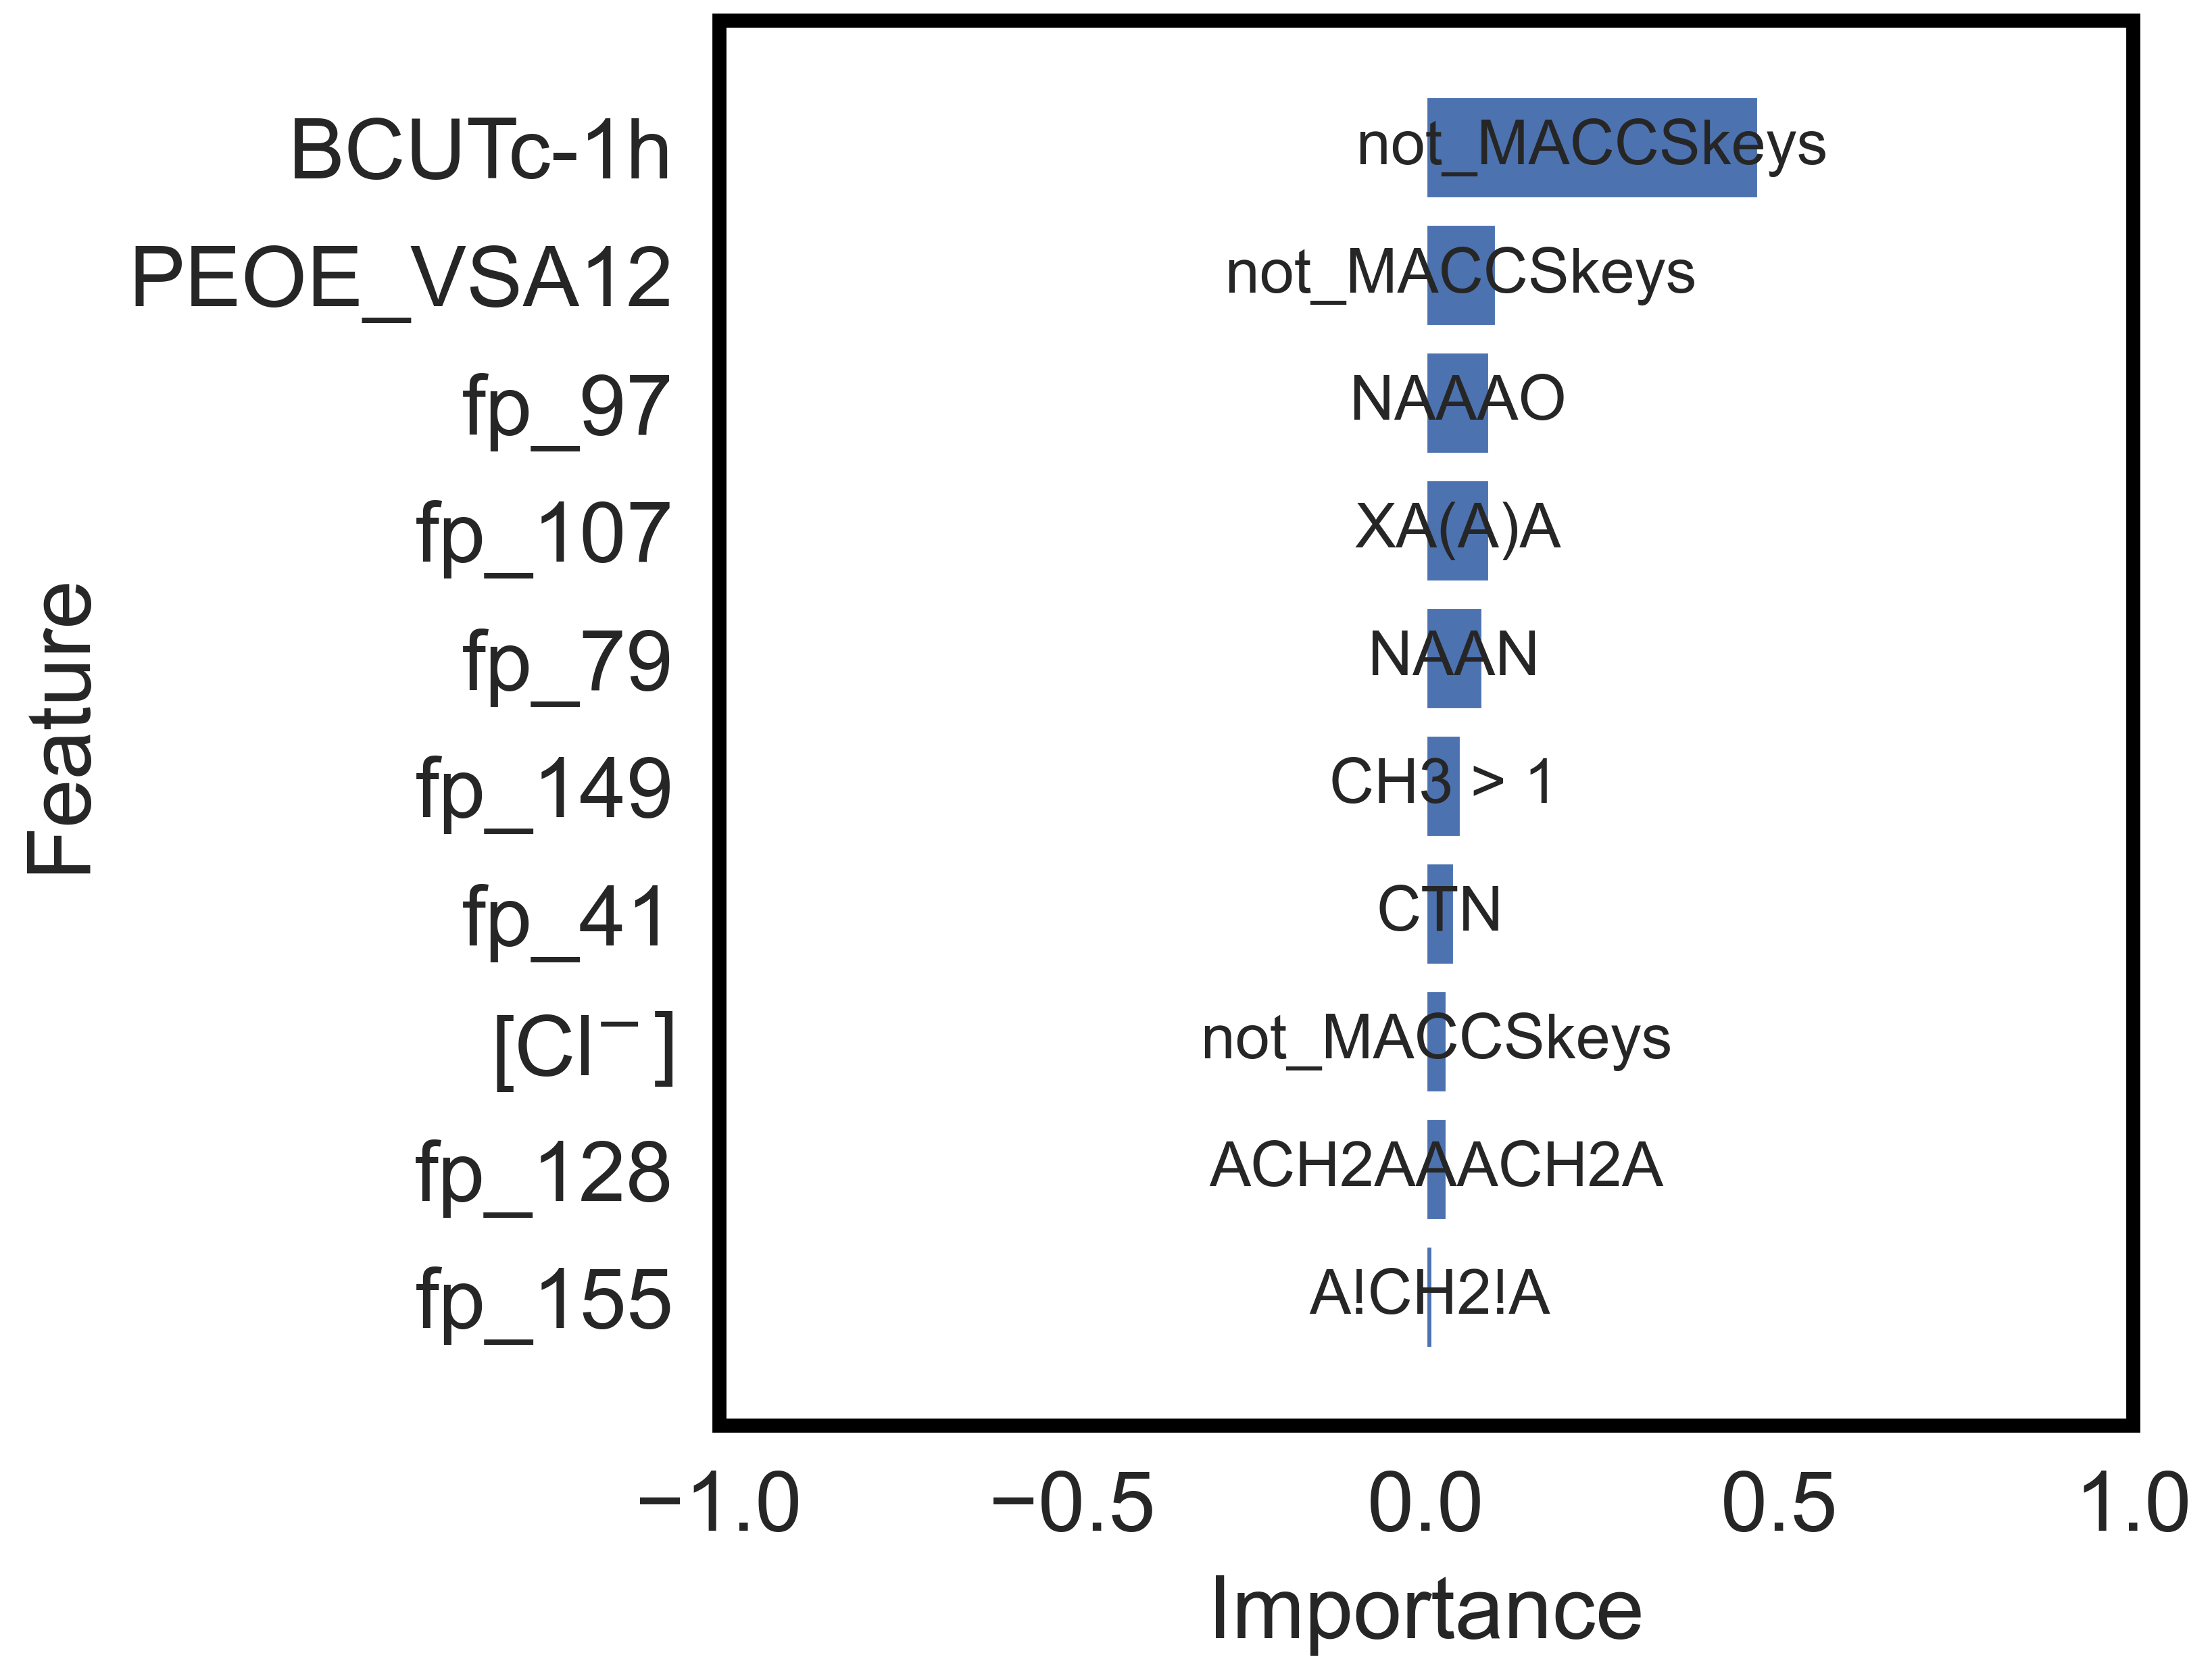

In [66]:
# plot the N most important features
N = 10
fontsize = 30

fig, axes = plt.subplots(figsize=(9,9), dpi=300)
a = axes.barh(df2_feature_importance['feature'][:N], 
          df2_feature_importance['importance'][:N])

axes.bar_label(a, labels=df2_feature_importance['SMARTS_label'][:N], label_type='center',
               fontsize=fontsize-8)
axes.set_ylim([-1, N])
axes.set_xlim([-1, 1])
axes.set_xlabel('Importance', fontsize=fontsize+1, labelpad=10)
axes.set_ylabel('Feature', fontsize=fontsize+1, labelpad=10)
axes.tick_params(labelsize=fontsize)
axes.grid(False)
axes.invert_yaxis()
axes.patch.set_facecolor('white')
axes.patch.set_edgecolor('black')
axes.patch.set_linewidth(5)
axes.tick_params(pad=10)

for _, spine in axes.spines.items():
    spine.set_visible(False)

fig.savefig("fig_feature_importance_{}_label.png".format(model_name))

In [67]:
# create rdkit molecules from SMARTS in  and add Feature and Importance as properties
mols_smarts = []

for i, row in df2_feature_importance.sort_values('importance', ascending=False).iterrows():
    if row['SMARTS'] != 'not_MACCSkeys':
        smarts = row['SMARTS']
        smarts_label = row['SMARTS_label']
        if smarts == '?':
            print(f'Error creating mol from SMARTS label: {smarts_label}')
            pass
        else:
            mol = Chem.MolFromSmarts(smarts)
            ## sanitize 
            mol.UpdatePropertyCache(strict=False)
            mol.SetProp('Feature', row['feature'])
            mol.SetProp('Importance', str(row['importance']))
            mols_smarts.append(mol)

# check invalid mol objects
invalid_mols = [m for m in mols_smarts if m is None]
print(f'Invalid mol objects: {len(invalid_mols)}')

Error creating mol from SMARTS label: Aromatic Ring > 1
Invalid mol objects: 0


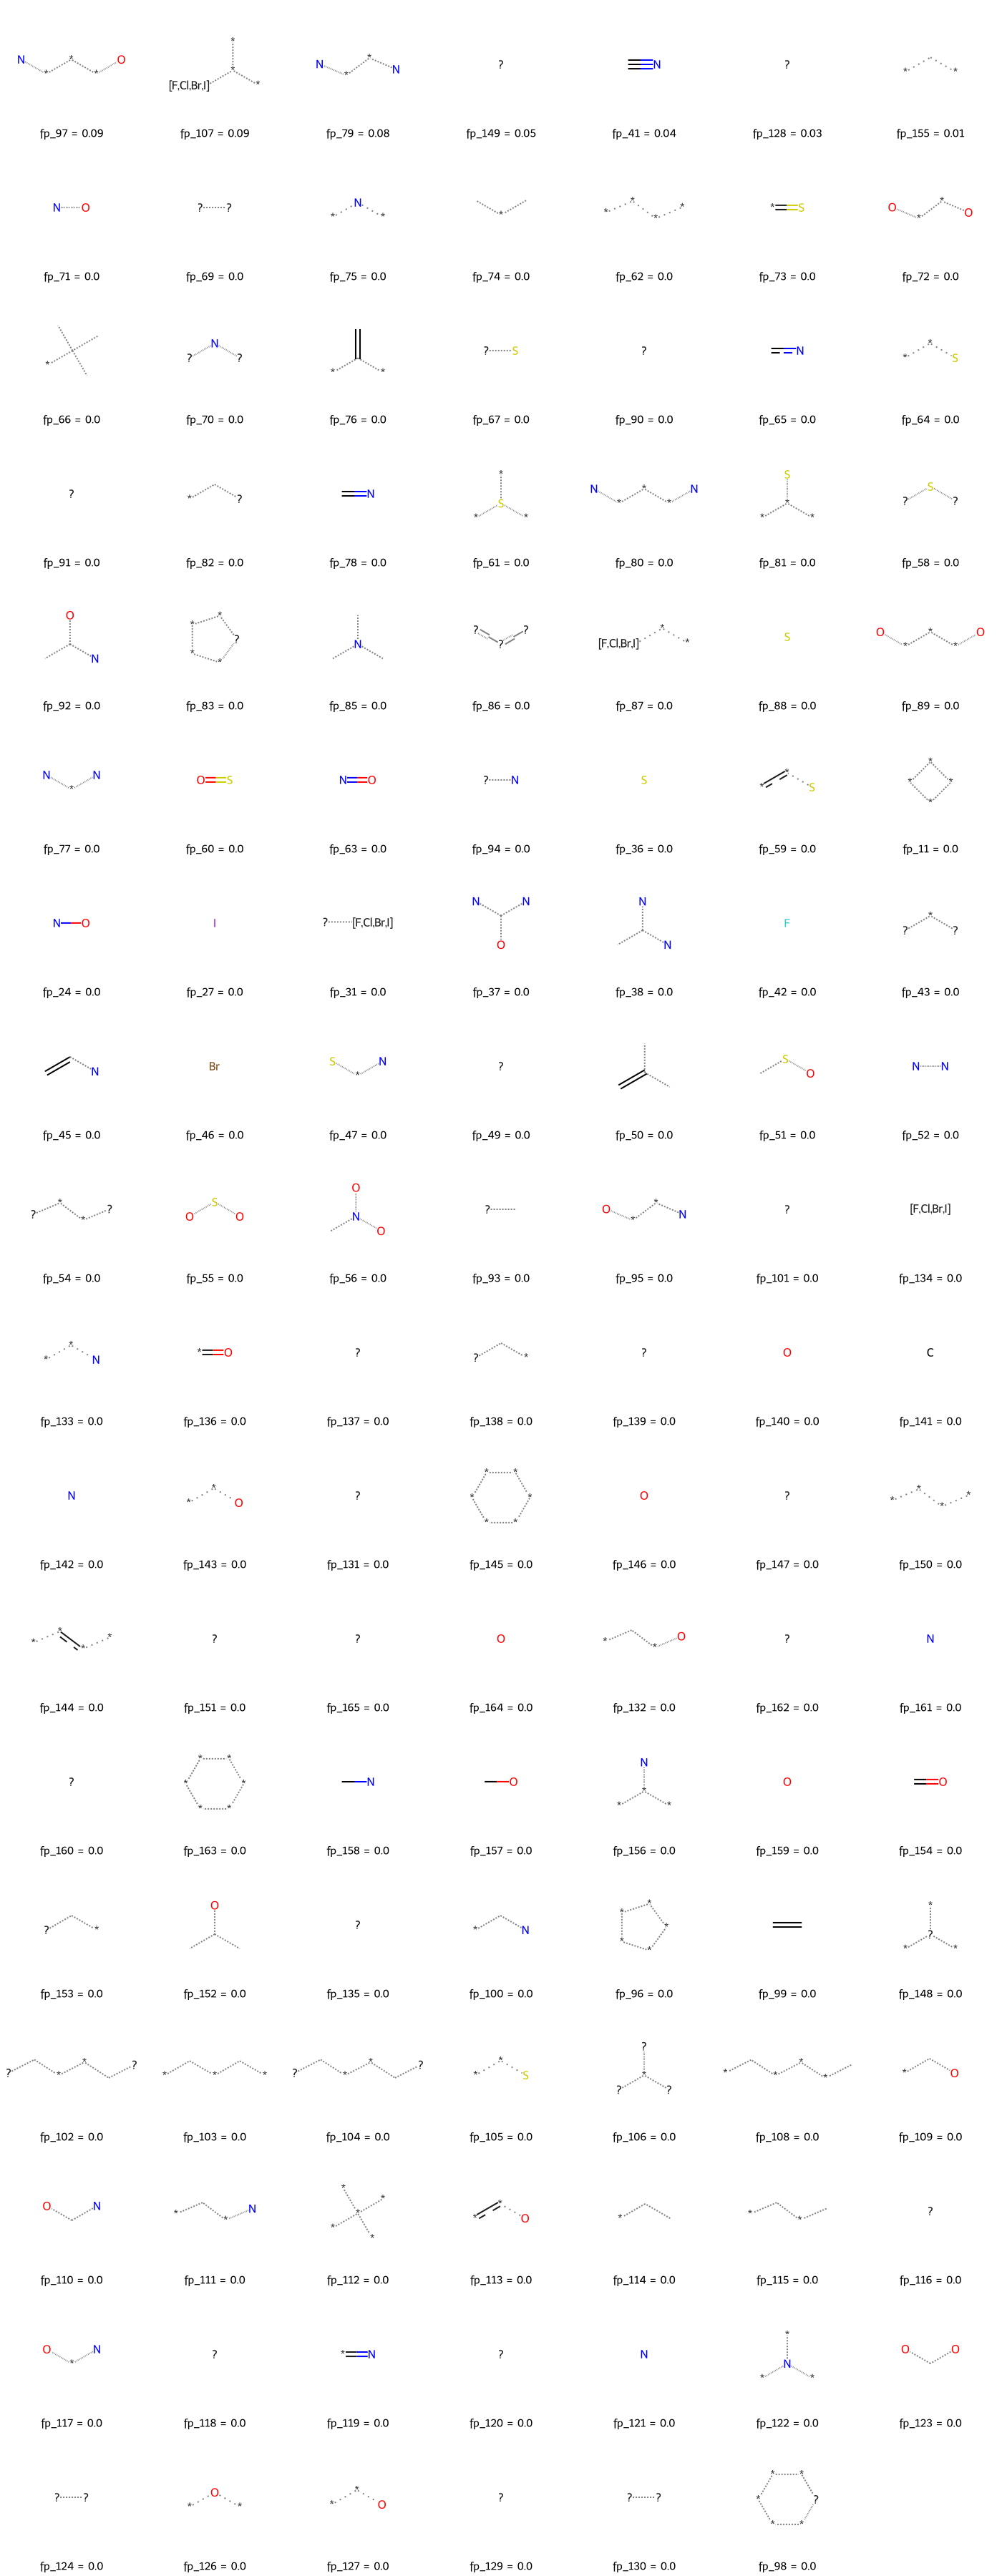

In [68]:
img=Draw.MolsToGridImage(mols_smarts, 
                         molsPerRow=7,
                        subImgSize=(200, 200),
                        maxMols=200,
                         legends=[x.GetProp('Feature') + ' = ' + x.GetProp('Importance') for x in mols_smarts], returnPNG=False)
img.save('fig_feature_importance_MACCS.png')
img

In [69]:
train_mols = [Chem.MolFromSmiles(x) for x in train_data['canonical_smiles']]
train_predictions = clf_model.predict(Xtrain)
test_mols = [Chem.MolFromSmiles(x) for x in test_data['canonical_smiles']]
test_predictions = clf_model.predict(Xtest)

all_smiles = np.concatenate((train_data['canonical_smiles'], test_data['canonical_smiles']))
all_mols = np.concatenate((train_mols, test_mols))
all_knowns = np.concatenate((Ytrain['classes'], Ytest))
all_predictions = np.concatenate((train_predictions, test_predictions))

In [70]:
df_all_mols = pd.DataFrame({'smiles': all_smiles, 
                            'mols': all_mols, 
                            'knowns': all_knowns, 
                            'predictions': all_predictions})

df_all_mols['set'] = ['train' if x in train_mols else 'test' for x in df_all_mols['mols']]
df_all_mols

,smiles,mols,knowns,predictions,set
0,CC(C)CCNC(=S)Nc1cccc2cc[nH]c12,<rdkit.Chem.rdchem.Mol object at 0x13c5888e0>,1,1,train
1,CCCCNC(=O)NCCC(C)C,<rdkit.Chem.rdchem.Mol object at 0x13c588a00>,0,0,train
2,CCCCNC(=S)NCCC(C)C,<rdkit.Chem.rdchem.Mol object at 0x13c588ac0>,1,0,train
3,CC(C)CCNC(=O)Nc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x13c588b20>,0,0,train
4,CC(C)CCNC(=S)Nc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x13c588b80>,0,0,train
...,...,...,...,...,...
299,FS(F)(F)(F)(F)c1ccc(NC(=S)Nc2cccc3c2[nH]c2c(NC...,<rdkit.Chem.rdchem.Mol object at 0x1324f0ca0>,1,1,test
300,FC(F)(F)c1cc(NC(=S)Nc2cccc3c2[nH]c2c(NC(=S)Nc4...,<rdkit.Chem.rdchem.Mol object at 0x1324f0be0>,1,1,test
301,FC(F)(F)c1ccc(NC(=S)Nc2cccc3c2[nH]c2c(NC(=S)Nc...,<rdkit.Chem.rdchem.Mol object at 0x1324f05e0>,1,1,test
302,S=C(Nc1ccccc1)Nc1cccc2c1[nH]c1c(NC(=S)Nc3ccccc...,<rdkit.Chem.rdchem.Mol object at 0x1324f0400>,0,0,test


In [71]:
# create folder to streo highlight
os.makedirs('highlight_mols', exist_ok=True)

In [72]:
help(Draw.MolsToGridImage)

Help on function ShowMols in module rdkit.Chem.Draw.IPythonConsole:

ShowMols(mols, maxMols=50, **kwargs)



In [73]:
highlight_fpids = [97, 107, 79, 149, 41, 128, 155]

In [74]:
for highlight_fpid in highlight_fpids:
    print(highlight_fpid)
    highlight_patt = Chem.MolFromSmarts(smartsPatts[highlight_fpid][0])
    highlight_importance = df2_feature_importance[df2_feature_importance['feature'] == f'fp_{highlight_fpid}']['importance'].values[0]


    highlight_mols =[]
    draw_mols = []
    for m in df_all_mols['mols']:

        highlight = m.GetSubstructMatch(highlight_patt)
        if highlight:
            highlight_mols.append(highlight)
            m.SetProp('set', df_all_mols['set'][df_all_mols['mols'] == m].values[0])
            m.SetProp('Known', str(df_all_mols['knowns'][df_all_mols['mols'] == m].values[0]))
            m.SetProp('Prediction', str(df_all_mols['predictions'][df_all_mols['mols'] == m].values[0]))
            draw_mols.append(m)
        else:
            pass


    img2 = Draw.MolsToGridImage(draw_mols, 
                                highlightAtomLists = highlight_mols, 
                                legends=[x.GetProp('set') + ', ' + x.GetProp('Known') + ', ' + x.GetProp('Prediction') for x in draw_mols],
                                molsPerRow=5, maxMols=400, subImgSize=(500, 500), returnPNG=False)
    img2.save(f'highlight_mols/highlight_mols_{highlight_fpid}_{highlight_importance}.png')
    img2

97
107
79
149
41
128
155


In [75]:
def highlight_important_maccs_keys_test(smiles_list, predictions, maccs_keys_dict, ids_to_plot, colors):
    # https://rdkit.blogspot.com/2015/02/new-drawing-code.html
    # https://gist.github.com/greglandrum/d85d5693e57c306e30057ec4d4d11342

    
    from rdkit.Chem.Draw import IPythonConsole
    from IPython.display import SVG

    import os
    try:
        import skunk
    except ImportError:
        !pip install skunk
        import skunk

    try:
        import cairosvg
    except ImportError:
        !pip install cairosvg
        import cairosvg

    svg_dir = "test_highlighted_maccs_keys"
    if not os.path.exists(svg_dir):
        os.makedirs(svg_dir)
    
    mols_plot = [Chem.MolFromSmarts(maccs_keys_dict[key][0]) for key in ids_to_plot]
    for i in range(len(smiles_list)):
        print(f'test_{i}')
        smi = smiles_list[i]
        m = Chem.MolFromSmiles(smi)
                    
        
        highlights_colors = []
        highlights = []
        for p in range(len(mols_plot)):
            patt = mols_plot[p]
            c = colors[p]
            match = m.GetSubstructMatch(patt)
            if match:
                print(' - ', match)
                highlights.append(match)
                for h in match:
                    highlights_colors.append(c)

        highlights = [list(h) for h in highlights]
        highlights = [item for sublist in highlights for item in sublist]
        print(' - highlights:', highlights)
        print(' - highlights_colors:', highlights_colors)

        # create a dictionary of highlights and colors
        highlights_dict = dict(zip(highlights, highlights_colors))

        drawer = rdMolDraw2D.MolDraw2DSVG(500,500)
        drawer.drawOptions().useBWAtomPalette()
        drawer.DrawMolecule(m,highlightAtoms=highlights, highlightAtomColors=highlights_dict, highlightBonds=[], highlightBondColors={})
        drawer.FinishDrawing()
        svg1 = drawer.GetDrawingText().replace('svg:','')
        with open(os.path.join(svg_dir, f"testid_{i}.svg"), "w") as f:
            f.write(svg1)

    svg_files = [os.path.join(svg_dir, f"testid_{i}.svg") for i in range(len(smiles_list))]

    # set text size
    plt.rcParams.update({'font.size': 8})
    
    labels = []
    for i in range(len(smiles_list)):
        known = int(predictions['known'][i])
        pred = int(predictions['prediction'][i])
        labels.append(f"test {i} known: {known}, pred: {pred}")

    svg = skunk.layout_svgs(svgs=svg_files, labels=labels)

    cairosvg.svg2pdf(bytestring=svg, write_to='{}/test_highlighted_maccs_keys.pdf'.format(svg_dir))

test_0
 - highlights: []
 - highlights_colors: []
test_1
 - highlights: []
 - highlights_colors: []
test_2
 - highlights: []
 - highlights_colors: []
test_3
 - highlights: []
 - highlights_colors: []
test_4
 -  (0,)
 -  (0,)
 -  (0, 1, 2)
 - highlights: [0, 0, 0, 1, 2]
 - highlights_colors: [(1, 1, 0), (0, 1, 1), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]
test_5
 -  (9, 10, 15, 16)
 - highlights: [9, 10, 15, 16]
 - highlights_colors: [(0, 0, 1), (0, 0, 1), (0, 0, 1), (0, 0, 1)]
test_6
 -  (12, 13, 18, 19)
 - highlights: [12, 13, 18, 19]
 - highlights_colors: [(0, 0, 1), (0, 0, 1), (0, 0, 1), (0, 0, 1)]
test_7
 -  (8, 7, 6, 9)
 -  (13, 14, 19, 20)
 - highlights: [8, 7, 6, 9, 13, 14, 19, 20]
 - highlights_colors: [(1, 0, 0), (1, 0, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1), (0, 0, 1), (0, 0, 1), (0, 0, 1)]
test_8
 - highlights: []
 - highlights_colors: []
test_9
 -  (0,)
 -  (0, 1, 2)
 - highlights: [0, 0, 1, 2]
 - highlights_colors: [(1, 1, 0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 

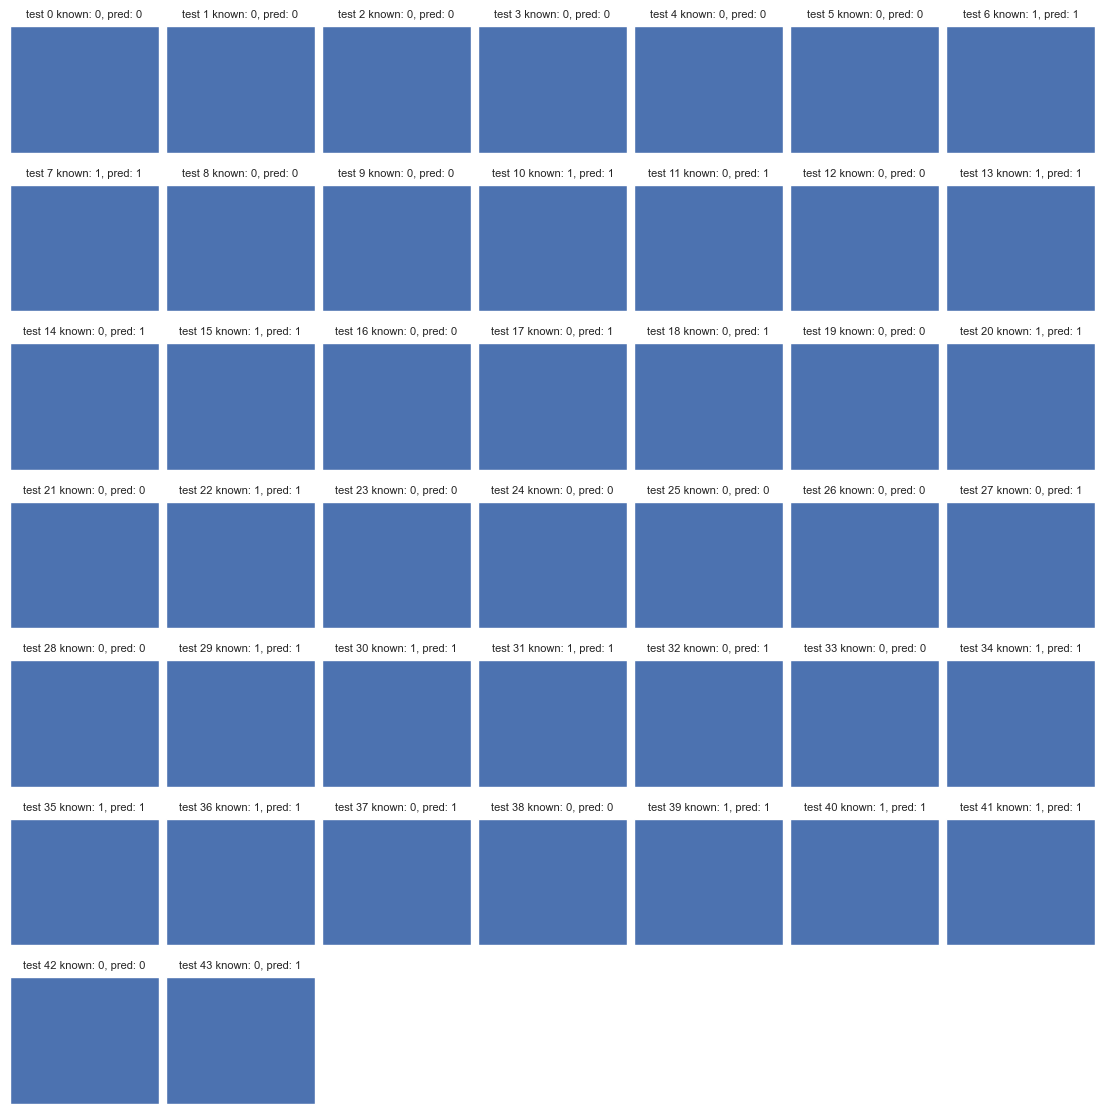

In [76]:
# get a list of colors
colors = [(0,1,0), # green
            (1,0,0), # red
            (0,0,1), # blue
            (1,1,0), # yellow
            (1,0,1), # magenta
            (0,1,1), # cyan
            (0.5,0.5,0.5)] # grey

MACCSkey_ids = [97, 107, 79, 149, 41, 128, 155]

# for test data
df_predictions_lr_test = pd.read_csv('Decision_Tree/all_predictions.csv')

highlight_important_maccs_keys_test(smiles_list = test_data['canonical_smiles'], 
                                predictions = df_predictions_lr_test,
                                maccs_keys_dict = smartsPatts, 
                                ids_to_plot = MACCSkey_ids, colors=colors)

In [77]:
def highlight_important_maccs_keys_train(smiles_list, predictions, maccs_keys_dict, ids_to_plot, colors):
    # https://rdkit.blogspot.com/2015/02/new-drawing-code.html
    # https://gist.github.com/greglandrum/d85d5693e57c306e30057ec4d4d11342

    
    from rdkit.Chem.Draw import IPythonConsole
    from IPython.display import SVG

    import os
    try:
        import skunk
    except ImportError:
        !pip install skunk
        import skunk

    try:
        import cairosvg
    except ImportError:
        !pip install cairosvg
        import cairosvg

    svg_dir = "train_highlighted_maccs_keys"
    if not os.path.exists(svg_dir):
        os.makedirs(svg_dir)
    
    mols_plot = [Chem.MolFromSmarts(maccs_keys_dict[key][0]) for key in ids_to_plot]
    for i in range(len(smiles_list)):
        print(f'train_{i}')
        smi = smiles_list[i]
        m = Chem.MolFromSmiles(smi)                    
        
        highlights_colors = []
        highlights = []
        for p in range(len(mols_plot)):
            patt = mols_plot[p]
            c = colors[p]
            match = m.GetSubstructMatch(patt)
            if match:
                print(' - ', match)
                highlights.append(match)
                for h in match:
                    highlights_colors.append(c)

        highlights = [list(h) for h in highlights]
        highlights = [item for sublist in highlights for item in sublist]
        print(' - highlights:', highlights)
        print(' - highlights_colors:', highlights_colors)

        # create a dictionary of highlights and colors
        highlights_dict = dict(zip(highlights, highlights_colors))

        drawer = rdMolDraw2D.MolDraw2DSVG(500,500)
        drawer.drawOptions().useBWAtomPalette()
        drawer.DrawMolecule(m,highlightAtoms=highlights, highlightAtomColors=highlights_dict, highlightBonds=[], highlightBondColors={})
        drawer.FinishDrawing()
        svg1 = drawer.GetDrawingText().replace('svg:','')
        with open(os.path.join(svg_dir, f"trainid_{i}.svg"), "w") as f:
            f.write(svg1)

    svg_files = [os.path.join(svg_dir, f"trainid_{i}.svg") for i in range(len(smiles_list))]

    # set text size
    plt.rcParams.update({'font.size': 8})
    
    labels = []
    for i in range(len(smiles_list)):
        known = int(predictions['known'][i])
        pred = int(predictions['prediction'][i])
        labels.append(f"train {i} known: {known}, pred: {pred}")

    svg = skunk.layout_svgs(svgs=svg_files, labels=labels)

    cairosvg.svg2pdf(bytestring=svg, write_to='{}/train_highlighted_maccs_keys.pdf'.format(svg_dir), dpi=300)
    

[1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0
 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0
 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1
 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1
 1]
     classes
0          1
1          0
2          1
3          0
4          0
..       ...
255        1
256        1
257        0
258        1
259        1

[260 rows x 1 columns]
train_0
 -  (8, 9, 17, 16)
 -  (0,)
 -  (1, 3, 4)
 - highlights: [8, 9, 17, 16, 0, 1, 3, 4]
 - highlights_colors: [(0, 0, 1), (0, 0, 1), (0, 0, 1), (0, 0, 1), (1, 1, 0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]
train_1
 -  (0,)
 -  (2,)
 -  (0, 1, 2)
 - highlights: [0, 2, 0, 1, 2]

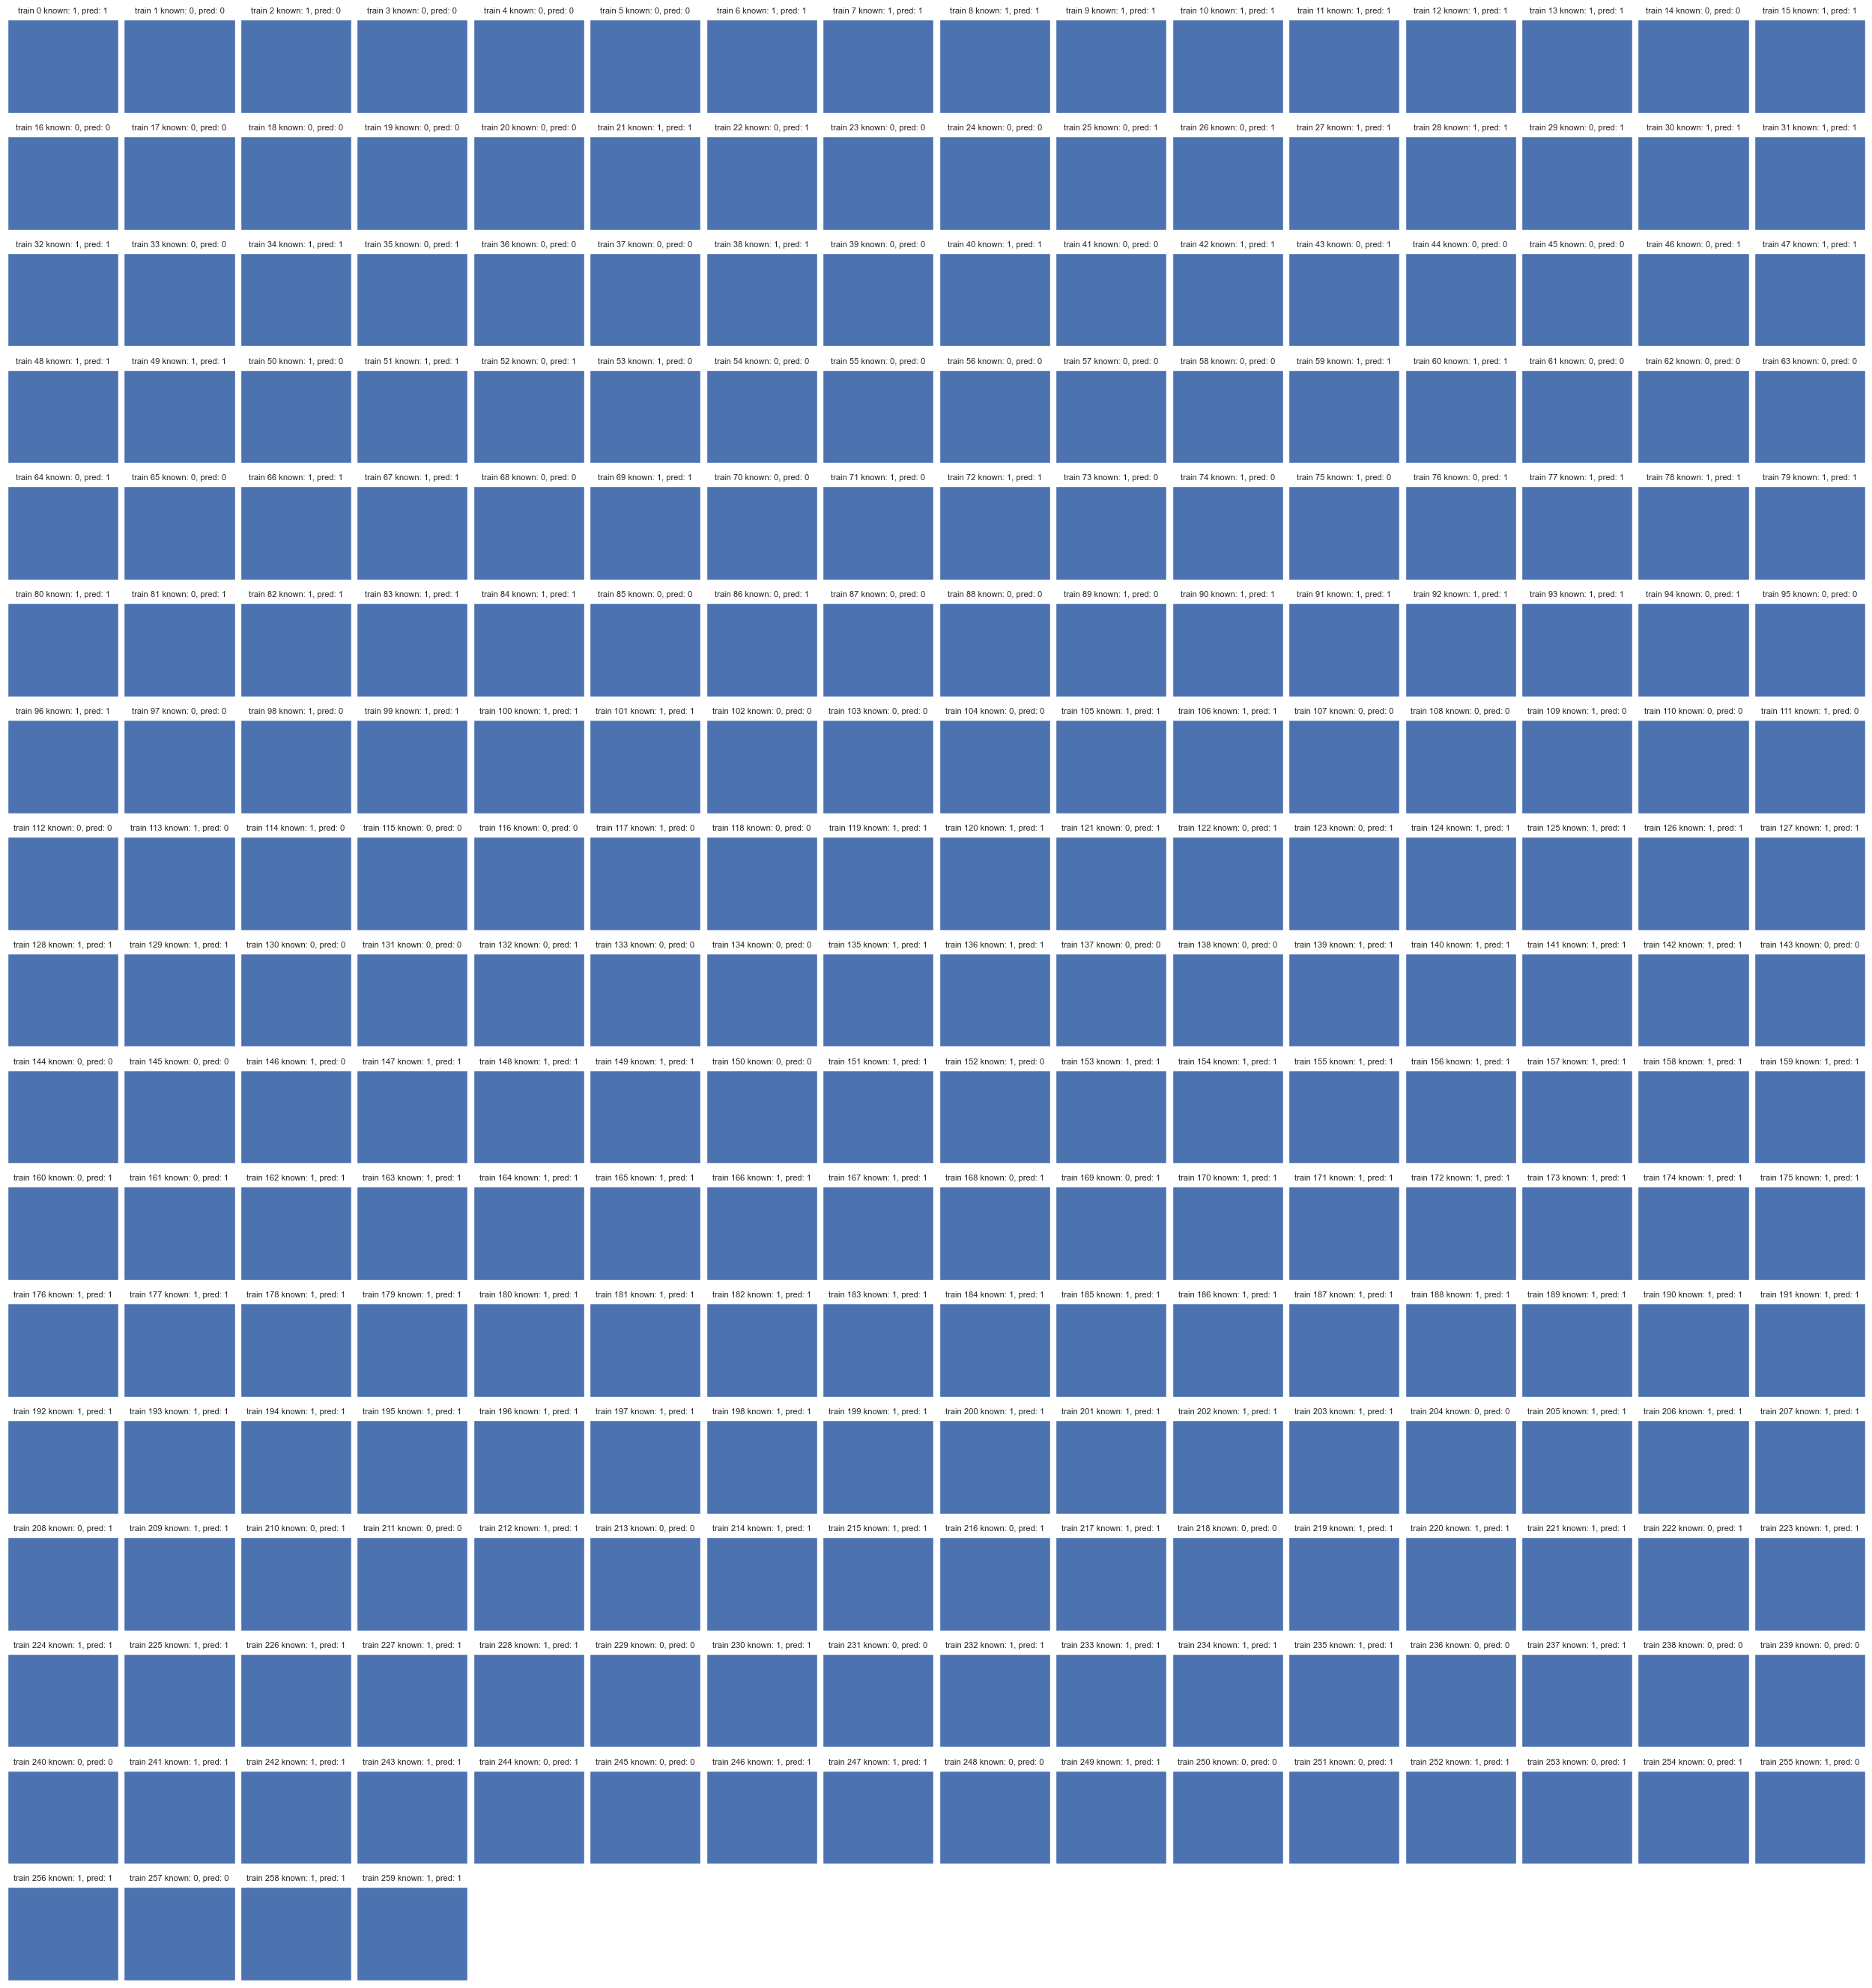

In [78]:
# for train data
Ytrain_predictions = clf_shap.predict(Xtrain)
print(Ytrain_predictions)
print(Ytrain)

df_predictions_lr_train= pd.DataFrame({'known': Ytrain['classes'], 'prediction': Ytrain_predictions})

highlight_important_maccs_keys_train(smiles_list = train_data['canonical_smiles'],
                                predictions = df_predictions_lr_train,
                                maccs_keys_dict = smartsPatts, 
                                ids_to_plot = MACCSkey_ids, colors=colors)
                                